In [2]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import time
import requests
from sklearn.preprocessing import LabelEncoder
from matplotlib.ticker import FuncFormatter

pd.set_option('display.max_columns', None)

The goal of this notebook is to verify the data linking and cleaning process by manually inspecting the linked fires and comparing them against the original buildings dataset and the original FEMA data.

In [3]:
vet = pd.read_csv('./ph_fires_matched_2.1.csv')

In [4]:
public = pd.read_csv('./data/Public_Housing_Buildings.csv')
public.columns = [x.lower() for x in public.columns]

C:\Users\jackv\AppData\Local\Temp\ipykernel_11376\2237559633.py:1: DtypeWarning: Columns (104) have mixed types. Specify dtype option on import or set low_memory=False.
  public = pd.read_csv('./data/Public_Housing_Buildings.csv')


In [5]:
public.std_addr = public.std_addr.fillna('MISSING')

In [6]:
iks = pd.read_csv('./full_fema_matches.csv')
iks = set(iks.INCIDENT_KEY.values)

In [7]:
doubled = tuple(list(iks) + list(iks))

In [8]:
params = ''
for _ in range(len(iks)):
    params = params + '?,'
params = params[:-1]

conn = sqlite3.Connection('./data/nfirs/fire_data.db')
cur = conn.cursor()
query_pt1 = """
    select        
        ia.INCIDENT_KEY as ia_INCIDENT_KEY, ia.STATE as ia_STATE, ia.FDID as ia_FDID, ia.INC_DATE as ia_INC_DATE, ia.INC_NO as ia_INC_NO, ia.EXP_NO as ia_EXP_NO, ia.LOC_TYPE as ia_LOC_TYPE, ia.NUM_MILE as ia_NUM_MILE, ia.STREET_PRE as ia_STREET_PRE, ia.STREETNAME as ia_STREETNAME, ia.STREETTYPE as ia_STREETTYPE, ia.STREETSUF as ia_STREETSUF, ia.APT_NO as ia_APT_NO, ia.CITY as ia_CITY, ia.STATE_ID as ia_STATE_ID, ia.ZIP5 as ia_ZIP5, ia.ZIP4 as ia_ZIP4, ia.X_STREET as ia_X_STREET, ia.address as ia_address, ia.INC_YEAR as ia_INC_YEAR,
        bi.INCIDENT_KEY as bi_INCIDENT_KEY, bi.STATE as bi_STATE, bi.FDID as bi_FDID, bi.INC_DATE as bi_INC_DATE, bi.INC_NO as bi_INC_NO, bi.EXP_NO as bi_EXP_NO, bi.VERSION as bi_VERSION, bi.DEPT_STA as bi_DEPT_STA, bi.INC_TYPE as bi_INC_TYPE, bi.ADD_WILD as bi_ADD_WILD, bi.AID as bi_AID, bi.ALARM as bi_ALARM, bi.ARRIVAL as bi_ARRIVAL, bi.INC_CONT as bi_INC_CONT, bi.LU_CLEAR as bi_LU_CLEAR, bi.SHIFT as bi_SHIFT, bi.ALARMS as bi_ALARMS, bi.DISTRICT as bi_DISTRICT, bi.ACT_TAK1 as bi_ACT_TAK1, bi.ACT_TAK2 as bi_ACT_TAK2, bi.ACT_TAK3 as bi_ACT_TAK3, bi.APP_MOD as bi_APP_MOD, bi.SUP_APP as bi_SUP_APP, bi.EMS_APP as bi_EMS_APP, bi.OTH_APP as bi_OTH_APP, bi.SUP_PER as bi_SUP_PER, bi.EMS_PER as bi_EMS_PER, bi.OTH_PER as bi_OTH_PER, bi.RESOU_AID as bi_RESOU_AID, bi.PROP_LOSS as bi_PROP_LOSS, bi.CONT_LOSS as bi_CONT_LOSS, bi.PROP_VAL as bi_PROP_VAL, bi.CONT_VAL as bi_CONT_VAL, bi.FF_DEATH as bi_FF_DEATH, bi.OTH_DEATH as bi_OTH_DEATH, bi.FF_INJ as bi_FF_INJ, bi.OTH_INJ as bi_OTH_INJ, bi.DET_ALERT as bi_DET_ALERT, bi.HAZ_REL as bi_HAZ_REL, bi.MIXED_USE as bi_MIXED_USE, bi.PROP_USE as bi_PROP_USE, bi.CENSUS as bi_CENSUS
    from incident_address ia
    join basic_incident bi using (INCIDENT_KEY)
    where bi.INCIDENT_KEY in (
"""
query_pt2 = """
) and ia.INCIDENT_KEY in (
"""
query_pt3 = ")"

cur.execute(query_pt1 + params + query_pt2 + params + query_pt3, doubled)
df = cur.fetchall()
columns = [desc[0] for desc in cur.description]
df = pd.DataFrame(df, columns=columns)

In [9]:
df.columns = [x.lower() for x in df.columns]

We'll start by looking at the buildings with the most fires, which likley we care about the most.

In [10]:
vet['total_indoor'] = vet[[f'building_fires_{year}' for year in range(2012, 2022)]].sum(axis=1)
vet = vet.sort_values('total_indoor', ascending=False)

In [11]:
vet['total_111'] = vet[[f'inc_type_111_{year}' for year in range(2012, 2022)]].sum(axis=1)

In [12]:
vet[['objectid','corrected_address','corrected_unit','std_city',
'std_st','std_zip5','total_dwelling_units', 'building_type_code_es', 'total_indoor']].head()

,objectid,corrected_address,corrected_unit,std_city,std_st,std_zip5,total_dwelling_units,building_type_code_es,total_indoor
118205,5263,630 W STATE ST,NaN,TRENTON,NJ,8618,150,1,329.0
132747,21013,3700 NEW JERSEY AVE,NaN,WILDWOOD,NJ,8260,98,1,117.0
49885,181843,1114 S 4TH ST,NaN,LOUISVILLE,KY,40203,159,1,98.0
4100,115577,1080 TERRACE ST,NaN,MUSKEGON,MI,49442,160,1,85.0
98653,84812,735 BROADWAY ST,NaN,LOWELL,MA,1854,90,1,84.0


##### TRENTON, NJ

In [13]:
display(public[
    (public.std_addr.str.contains('630')) &
    (public.std_addr.str.contains('State')) &
    (public.std_city == 'Trenton')
])

v = df[
    (df.ia_state == 'NJ') &
    (df.ia_city == 'TRENTON') &
    (df.ia_num_mile == 630)
]
print(len(v))
display(v.groupby('bi_inc_type').size())
display(v.groupby('ia_inc_year').size())

print(
    v.bi_prop_loss.sum(),
    v.bi_cont_loss.sum(),
    v.bi_oth_death.sum(),
    v.bi_oth_inj.sum(),
)
v[v.bi_inc_type == 111]

,x,y,objectid,participant_code,formal_participant_name,development_code,project_name,building_name,building_number,building_type_code,building_status_type_code,national_bldg_id,construct_date,dofa_actual_dt,total_dwelling_units,acc_units,total_occupied,regular_vacant,total_units,pct_occupied,number_reported,pct_reported,months_since_report,pct_movein,people_per_unit,people_total,rent_per_month,spending_per_month,spending_per_month_prev_yr,hh_income,person_income,pct_lt5k,pct_5k_lt10k,pct_10k_lt15k,pct_15k_lt20k,pct_ge20k,pct_wage_major,pct_welfare_major,pct_other_major,pct_median,pct_lt50_median,pct_lt30_median,pct_2adults,pct_1adult,pct_female_head,pct_female_head_child,pct_disabled_lt62,pct_disabled_ge62,pct_disabled_all,pct_lt24_head,pct_age25_50,pct_age51_61,pct_age62plus,pct_age85plus,pct_minority,pct_black,pct_native_american,pct_asian,pct_hispanic,months_waiting,months_from_movein,pct_utility_allow,ave_util_allow,pct_bed1,pct_bed2,pct_bed3,pct_overhoused,tminority,tpoverty,tpct_ownsfd,chldrn_mbr_cnt,eldly_prcnt,pct_disabled_lt62_all,pct_lt80_median,median_inc_amnt,state2kx,cnty_nm2kx,cnty2kx,tract2kx,bg2kx,block2kx,dpvact,dpvnost,curcnty_nm,curcnty,curcosub,curcosub_nm,place2kx,place_nm2kx,place_cc2kx,place_inc2kx,msa,msa_nm,cbsa,cbsa_nm,necta,necta_nm,metro,micro,fcd_fips91,hlc,dpv,dpvrc,std_addr,urb_out,std_city,std_st,std_zip5,std_zip9,zip_class,zcta2kx,dpbc,dpbc_cksum,std_zip11,addr_type,apt_no,apt_type,c1pgrc,c1pprb,c1pdrc,c1psrc,c1parc,c1pzrc,msgusps,lat,lon,rc2kx,stm2kx,lvl2kx,ur,msg2kx,county_level,place_level,tract_level,blkgrp_level,rad_chap_indr,rad_type,last_updt_dttm,annl_expns_amnt,annl_expns_amnt_prev_yr,pha_total_units,dev_buil_nu_entrance,ha_phn_num,ha_fax_num,ha_email_addr_text,exec_dir_phone,exec_dir_fax,exec_dir_email
5262,-74.783478,40.228398,5263,NJ005,Trenton Housing Authority,NJ005000004,JOSEPHSON APTS,French Towers,CF01,ES,INAPCP,2.270610e+09,1970/03/30 00:00:00+00,1971/03/30 00:00:00+00,150,150,135,15,151,89.400002,134,99.260002,7,14.93,1.0,139,319,1043,935,13552,13064,1.5,9.77,66.169998,11.28,11.28,5.97,0.0,93.279999,11.75,98.510002,94.029999,0.0,0.0,47.009998,0.0,82.139999,58.970001,66.190002,0.0,5.22,36.57,58.209999,2.24,91.040001,77.610001,0.0,0.0,13.43,49,95,0.0,0,100.0,0.0,0.0,0.0,96.660004,47.209999,5.07,0,56.830002,33.810001,100.0,10704,34.0,Mercer,21.0,1102.0,3.0,3015.0,NaN,NaN,Mercer,21.0,74000.0,Trenton,74000.0,Trenton city,C5,NaN,8480.0,"Trenton, NJ PMSA",45940.0,"Trenton-Princeton, NJ Metropolitan Statistical...",99999.0,NaN,1.0,0.0,3412,3216.0,NaN,NaN,630 W State St,NaN,Trenton,NJ,8618.0,5572.0,NaN,8618.0,99.0,0.0,8.618557e+09,H,NaN,NaN,NaN,1.0,NaN,NaN,A,NaN,90% Overall probable correctness,40.228398,-74.783478,S,NaN,R,U,** Street-Level Rooftop **,34021.0,3474000.0,3.402100e+10,3.402100e+11,N,,2023/03/06 08:50:52+00,1689785,1560029.0,1495,NJ005000004CF01630,6092785042,6.096000e+09,NaN,6.092785e+09,6.093942e+09,jgarrett@tha-nj.org


329


bi_inc_type
111      1
113    327
118      1
dtype: int64

ia_inc_year
2012    58
2013    56
2014    71
2015    45
2016    37
2017    43
2018    17
2020     2
dtype: int64

0.0 0.0 0.0 0.0


,ia_incident_key,ia_state,ia_fdid,ia_inc_date,ia_inc_no,ia_exp_no,ia_loc_type,ia_num_mile,ia_street_pre,ia_streetname,ia_streettype,ia_streetsuf,ia_apt_no,ia_city,ia_state_id,ia_zip5,ia_zip4,ia_x_street,ia_address,ia_inc_year,bi_incident_key,bi_state,bi_fdid,bi_inc_date,bi_inc_no,bi_exp_no,bi_version,bi_dept_sta,bi_inc_type,bi_add_wild,bi_aid,bi_alarm,bi_arrival,bi_inc_cont,bi_lu_clear,bi_shift,bi_alarms,bi_district,bi_act_tak1,bi_act_tak2,bi_act_tak3,bi_app_mod,bi_sup_app,bi_ems_app,bi_oth_app,bi_sup_per,bi_ems_per,bi_oth_per,bi_resou_aid,bi_prop_loss,bi_cont_loss,bi_prop_val,bi_cont_val,bi_ff_death,bi_oth_death,bi_ff_inj,bi_oth_inj,bi_det_alert,bi_haz_rel,bi_mixed_use,bi_prop_use,bi_census
6657,NJ_11070_2202012_1201056_0,NJ,11070,2202012,1201056,0,1,630,W,STATE,ST,None,None,TRENTON,NJ,8618,NaN,COLONIAL AVE,630 W STATE ST,2012,NJ_11070_2202012_1201056_0,NJ,11070,2202012,1201056,0,5.0,S8,111,N,N,22020120357,22020120401.0,22020120401.0,2.202012e+10,None,1,None,11.0,-,None,Y,6.0,6.0,1.0,24.0,4.0,1.0,N,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,1,N,NN,429,None


This property consistently had fires, but the number has been reduced in recent years. They are mostly cooking fires and didn't cause damage.

##### WILDWOOD, NJ

In [14]:
public.std_addr.info()

<class 'pandas.core.series.Series'>
RangeIndex: 191885 entries, 0 to 191884
Series name: std_addr
Non-Null Count   Dtype 
--------------   ----- 
191885 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


In [15]:
display(public[
    (public.std_addr.str.contains('3700')) &
    (public.std_addr.str.contains('New Jersey')) &
    (public.std_city.str.contains('Wildwood')) &
    (public.building_type_code == 'ES')
])

v = df[
    (df.ia_state == 'NJ') &
    (df.ia_city == 'WILDWOOD') &
    (df.ia_num_mile == 3700) 
]
print(len(v))
display(v.groupby('bi_inc_type').size())
display(v.groupby('ia_inc_year').size())

print(
    v.bi_prop_loss.sum(),
    v.bi_cont_loss.sum(),
    v.bi_oth_death.sum(),
    v.bi_oth_inj.sum(),
)
v[v.bi_inc_type == 111]

,x,y,objectid,participant_code,formal_participant_name,development_code,project_name,building_name,building_number,building_type_code,building_status_type_code,national_bldg_id,construct_date,dofa_actual_dt,total_dwelling_units,acc_units,total_occupied,regular_vacant,total_units,pct_occupied,number_reported,pct_reported,months_since_report,pct_movein,people_per_unit,people_total,rent_per_month,spending_per_month,spending_per_month_prev_yr,hh_income,person_income,pct_lt5k,pct_5k_lt10k,pct_10k_lt15k,pct_15k_lt20k,pct_ge20k,pct_wage_major,pct_welfare_major,pct_other_major,pct_median,pct_lt50_median,pct_lt30_median,pct_2adults,pct_1adult,pct_female_head,pct_female_head_child,pct_disabled_lt62,pct_disabled_ge62,pct_disabled_all,pct_lt24_head,pct_age25_50,pct_age51_61,pct_age62plus,pct_age85plus,pct_minority,pct_black,pct_native_american,pct_asian,pct_hispanic,months_waiting,months_from_movein,pct_utility_allow,ave_util_allow,pct_bed1,pct_bed2,pct_bed3,pct_overhoused,tminority,tpoverty,tpct_ownsfd,chldrn_mbr_cnt,eldly_prcnt,pct_disabled_lt62_all,pct_lt80_median,median_inc_amnt,state2kx,cnty_nm2kx,cnty2kx,tract2kx,bg2kx,block2kx,dpvact,dpvnost,curcnty_nm,curcnty,curcosub,curcosub_nm,place2kx,place_nm2kx,place_cc2kx,place_inc2kx,msa,msa_nm,cbsa,cbsa_nm,necta,necta_nm,metro,micro,fcd_fips91,hlc,dpv,dpvrc,std_addr,urb_out,std_city,std_st,std_zip5,std_zip9,zip_class,zcta2kx,dpbc,dpbc_cksum,std_zip11,addr_type,apt_no,apt_type,c1pgrc,c1pprb,c1pdrc,c1psrc,c1parc,c1pzrc,msgusps,lat,lon,rc2kx,stm2kx,lvl2kx,ur,msg2kx,county_level,place_level,tract_level,blkgrp_level,rad_chap_indr,rad_type,last_updt_dttm,annl_expns_amnt,annl_expns_amnt_prev_yr,pha_total_units,dev_buil_nu_entrance,ha_phn_num,ha_fax_num,ha_email_addr_text,exec_dir_phone,exec_dir_fax,exec_dir_email
21012,-74.819181,38.991842,21013,NJ080,Wildwood Housing Authority,NJ080000002,SANDMAN TWS,SANDMAN TOWERS,1,ES,INAPCP,6.143610e+09,NaN,1977/11/30 00:00:00+00,98,98,95,3,100,95.0,95,100.0,0,15.79,1.0,96,368,580,526,15416,15255,0.0,3.16,56.84,23.16,16.84,1.05,0.0,98.949997,15.29,98.949997,83.160004,0.0,0.0,47.369999,0.0,100.0,82.089996,86.459999,0.0,0.0,29.469999,70.529999,3.16,42.110001,21.049999,1.05,2.11,17.889999,0,84,0.0,0,100.0,0.0,0.0,0.0,45.490002,24.030001,28.940001,0,70.830002,29.17,100.0,11909,34.0,Cape May,9.0,21500.0,1.0,1013.0,NaN,NaN,Cape May,9.0,81170.0,Wildwood,81170.0,Wildwood city,C5,NaN,560.0,"Atlantic-Cape May, NJ PMSA",36140.0,"Ocean City, NJ Metropolitan Statistical Area",99999.0,NaN,1.0,0.0,3402,3582.0,NaN,NaN,3700 New Jersey Ave,NaN,Wildwood,NJ,8260.0,6154.0,NaN,8260.0,99.0,0.0,8.260615e+09,H,NaN,NaN,NaN,1.0,NaN,NaN,A,NaN,90% Overall probable correctness,38.991842,-74.819181,S,NaN,R,U,** Street-Level Rooftop **,34009.0,3481170.0,3.400902e+10,3.400902e+11,N,,2023/03/06 08:50:52+00,660687,605672.0,168,NJ08000000211,8562656207,6.097294e+09,pdice@millvillehousing.org,6.097290e+09,NaN,bloyle@wildwoodhousing.org


117


bi_inc_type
113    114
118      3
dtype: int64

ia_inc_year
2012    17
2013    12
2014    16
2015    14
2016    27
2017    10
2018    14
2019     3
2020     4
dtype: int64

0.0 40.0 0.0 0.0


,ia_incident_key,ia_state,ia_fdid,ia_inc_date,ia_inc_no,ia_exp_no,ia_loc_type,ia_num_mile,ia_street_pre,ia_streetname,ia_streettype,ia_streetsuf,ia_apt_no,ia_city,ia_state_id,ia_zip5,ia_zip4,ia_x_street,ia_address,ia_inc_year,bi_incident_key,bi_state,bi_fdid,bi_inc_date,bi_inc_no,bi_exp_no,bi_version,bi_dept_sta,bi_inc_type,bi_add_wild,bi_aid,bi_alarm,bi_arrival,bi_inc_cont,bi_lu_clear,bi_shift,bi_alarms,bi_district,bi_act_tak1,bi_act_tak2,bi_act_tak3,bi_app_mod,bi_sup_app,bi_ems_app,bi_oth_app,bi_sup_per,bi_ems_per,bi_oth_per,bi_resou_aid,bi_prop_loss,bi_cont_loss,bi_prop_val,bi_cont_val,bi_ff_death,bi_oth_death,bi_ff_inj,bi_oth_inj,bi_det_alert,bi_haz_rel,bi_mixed_use,bi_prop_use,bi_census


Similar situation. Only cooking and trash fires. Decreased a lot recently.

##### LOUISVILLE, KY

In [16]:
display(public[
    (public.std_addr.str.contains('1114')) &
    (public.std_addr.str.contains('S 4')) &
    (public.std_city.str.contains('Louisville')) &
    (public.building_type_code == 'ES')
])

v = df[
    (df.ia_state == 'KY') &
    (df.ia_city == 'LOUISVILLE') &
    (df.ia_num_mile == 1114) 
]
print(len(v))
display(v.groupby('bi_inc_type').size())
display(v.groupby('ia_inc_year').size())

print(
    v.bi_prop_loss.sum(),
    v.bi_cont_loss.sum(),
    v.bi_oth_death.sum(),
    v.bi_oth_inj.sum(),
)
v[v.bi_inc_type == 111]

,x,y,objectid,participant_code,formal_participant_name,development_code,project_name,building_name,building_number,building_type_code,building_status_type_code,national_bldg_id,construct_date,dofa_actual_dt,total_dwelling_units,acc_units,total_occupied,regular_vacant,total_units,pct_occupied,number_reported,pct_reported,months_since_report,pct_movein,people_per_unit,people_total,rent_per_month,spending_per_month,spending_per_month_prev_yr,hh_income,person_income,pct_lt5k,pct_5k_lt10k,pct_10k_lt15k,pct_15k_lt20k,pct_ge20k,pct_wage_major,pct_welfare_major,pct_other_major,pct_median,pct_lt50_median,pct_lt30_median,pct_2adults,pct_1adult,pct_female_head,pct_female_head_child,pct_disabled_lt62,pct_disabled_ge62,pct_disabled_all,pct_lt24_head,pct_age25_50,pct_age51_61,pct_age62plus,pct_age85plus,pct_minority,pct_black,pct_native_american,pct_asian,pct_hispanic,months_waiting,months_from_movein,pct_utility_allow,ave_util_allow,pct_bed1,pct_bed2,pct_bed3,pct_overhoused,tminority,tpoverty,tpct_ownsfd,chldrn_mbr_cnt,eldly_prcnt,pct_disabled_lt62_all,pct_lt80_median,median_inc_amnt,state2kx,cnty_nm2kx,cnty2kx,tract2kx,bg2kx,block2kx,dpvact,dpvnost,curcnty_nm,curcnty,curcosub,curcosub_nm,place2kx,place_nm2kx,place_cc2kx,place_inc2kx,msa,msa_nm,cbsa,cbsa_nm,necta,necta_nm,metro,micro,fcd_fips91,hlc,dpv,dpvrc,std_addr,urb_out,std_city,std_st,std_zip5,std_zip9,zip_class,zcta2kx,dpbc,dpbc_cksum,std_zip11,addr_type,apt_no,apt_type,c1pgrc,c1pprb,c1pdrc,c1psrc,c1parc,c1pzrc,msgusps,lat,lon,rc2kx,stm2kx,lvl2kx,ur,msg2kx,county_level,place_level,tract_level,blkgrp_level,rad_chap_indr,rad_type,last_updt_dttm,annl_expns_amnt,annl_expns_amnt_prev_yr,pha_total_units,dev_buil_nu_entrance,ha_phn_num,ha_fax_num,ha_email_addr_text,exec_dir_phone,exec_dir_fax,exec_dir_email
181842,-85.760198,38.237005,181843,KY001,Louisville Metro Housing Authority,KY001000013,ST CATHERINE CT,ST CATHERINE CT BLDG 1,1301,ES,INAPCP,1.825900e+09,1972/05/18 00:00:00+00,1972/10/31 00:00:00+00,159,159,155,3,173,89.599998,155,100.0,7,9.68,1.1,166,216,720,641,11213,10470,4.96,31.209999,47.52,7.09,9.22,4.52,0.0,86.449997,13.7,96.769997,87.739998,0.0,0.0,47.099998,0.0,68.75,64.230003,63.25,0.0,3.23,17.42,79.349998,1.94,80.0,78.709999,0.0,1.29,0.0,0,111,0.0,0,100.0,0.0,0.0,0.0,47.32,32.830002,10.79,0,75.300003,14.46,100.0,10212,21.0,Jefferson,111.0,5100.0,2.0,2007.0,NaN,NaN,Jefferson,111.0,92106.0,Louisville Central,48006.0,Louisville/Jefferson County metro govern,C8,NaN,4520.0,"Louisville, KY-IN MSA",31140.0,"Louisville/Jefferson County, KY-IN Metropolita...",99999.0,NaN,1.0,0.0,2103,NaN,NaN,NaN,1114 S 4th St,NaN,Louisville,KY,40203.0,3158.0,NaN,40203.0,99.0,6.0,4.020332e+10,H,NaN,NaN,NaN,1.0,NaN,NaN,A,NaN,90% Overall probable correctness,38.237005,-85.760198,S,NaN,R,U,** Street-Level Rooftop **,21111.0,2148006.0,2.111101e+10,2.111101e+11,N,,2023/03/06 08:50:52+00,1338645,1168331.0,3739,KY00100001313011,5025693400,5.025693e+09,osanka@Lmha1.org,5.025693e+09,5.025693e+09,osanka@LMHA1.org


98


bi_inc_type
111     1
113    95
118     2
dtype: int64

ia_inc_year
2017     4
2018     2
2019    15
2020    33
2021    44
dtype: int64

0.0 0.0 0.0 0.0


,ia_incident_key,ia_state,ia_fdid,ia_inc_date,ia_inc_no,ia_exp_no,ia_loc_type,ia_num_mile,ia_street_pre,ia_streetname,ia_streettype,ia_streetsuf,ia_apt_no,ia_city,ia_state_id,ia_zip5,ia_zip4,ia_x_street,ia_address,ia_inc_year,bi_incident_key,bi_state,bi_fdid,bi_inc_date,bi_inc_no,bi_exp_no,bi_version,bi_dept_sta,bi_inc_type,bi_add_wild,bi_aid,bi_alarm,bi_arrival,bi_inc_cont,bi_lu_clear,bi_shift,bi_alarms,bi_district,bi_act_tak1,bi_act_tak2,bi_act_tak3,bi_app_mod,bi_sup_app,bi_ems_app,bi_oth_app,bi_sup_per,bi_ems_per,bi_oth_per,bi_resou_aid,bi_prop_loss,bi_cont_loss,bi_prop_val,bi_cont_val,bi_ff_death,bi_oth_death,bi_ff_inj,bi_oth_inj,bi_det_alert,bi_haz_rel,bi_mixed_use,bi_prop_use,bi_census
2584,KY_56290_12022020_0039447_0,KY,56290,12022020,39447,0,1,1114,S,4TH,ST,None,None,LOUISVILLE,KY,40203,NaN,None,1114 S 4TH ST,2020,KY_56290_12022020_0039447_0,KY,56290,12022020,39447,0,5.0,LFD,111,N,N,120220201608,120220201612.0,120220201613.0,1.202202e+11,2,None,2,87.0,None,None,Y,2.0,0.0,0.0,8.0,0.0,0.0,N,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,None,N,None,429,510000


##### MUSKEGON, MI

In [17]:
display(public[
    (public.std_addr.str.contains('1080')) &
    (public.std_addr.str.contains('St')) &
    (public.std_city.str.contains('Muskegon')) &
    (public.building_type_code == 'ES')
])

v = df[
    (df.ia_state == 'MI') &
    (df.ia_city == 'MUSKEGON') &
    (df.ia_num_mile == 1080) 
]
print(len(v))
display(v.groupby('bi_inc_type').size())
display(v.groupby(['ia_inc_year', 'bi_inc_type']).size())

print(
    v.bi_prop_loss.sum(),
    v.bi_cont_loss.sum(),
    v.bi_oth_death.sum(),
    v.bi_oth_inj.sum(),
)
v[v.bi_inc_type == 111]

,x,y,objectid,participant_code,formal_participant_name,development_code,project_name,building_name,building_number,building_type_code,building_status_type_code,national_bldg_id,construct_date,dofa_actual_dt,total_dwelling_units,acc_units,total_occupied,regular_vacant,total_units,pct_occupied,number_reported,pct_reported,months_since_report,pct_movein,people_per_unit,people_total,rent_per_month,spending_per_month,spending_per_month_prev_yr,hh_income,person_income,pct_lt5k,pct_5k_lt10k,pct_10k_lt15k,pct_15k_lt20k,pct_ge20k,pct_wage_major,pct_welfare_major,pct_other_major,pct_median,pct_lt50_median,pct_lt30_median,pct_2adults,pct_1adult,pct_female_head,pct_female_head_child,pct_disabled_lt62,pct_disabled_ge62,pct_disabled_all,pct_lt24_head,pct_age25_50,pct_age51_61,pct_age62plus,pct_age85plus,pct_minority,pct_black,pct_native_american,pct_asian,pct_hispanic,months_waiting,months_from_movein,pct_utility_allow,ave_util_allow,pct_bed1,pct_bed2,pct_bed3,pct_overhoused,tminority,tpoverty,tpct_ownsfd,chldrn_mbr_cnt,eldly_prcnt,pct_disabled_lt62_all,pct_lt80_median,median_inc_amnt,state2kx,cnty_nm2kx,cnty2kx,tract2kx,bg2kx,block2kx,dpvact,dpvnost,curcnty_nm,curcnty,curcosub,curcosub_nm,place2kx,place_nm2kx,place_cc2kx,place_inc2kx,msa,msa_nm,cbsa,cbsa_nm,necta,necta_nm,metro,micro,fcd_fips91,hlc,dpv,dpvrc,std_addr,urb_out,std_city,std_st,std_zip5,std_zip9,zip_class,zcta2kx,dpbc,dpbc_cksum,std_zip11,addr_type,apt_no,apt_type,c1pgrc,c1pprb,c1pdrc,c1psrc,c1parc,c1pzrc,msgusps,lat,lon,rc2kx,stm2kx,lvl2kx,ur,msg2kx,county_level,place_level,tract_level,blkgrp_level,rad_chap_indr,rad_type,last_updt_dttm,annl_expns_amnt,annl_expns_amnt_prev_yr,pha_total_units,dev_buil_nu_entrance,ha_phn_num,ha_fax_num,ha_email_addr_text,exec_dir_phone,exec_dir_fax,exec_dir_email
115576,-86.243015,43.23307,115577,MI066,Muskegon Housing Commission,MI066000001,HARTFORD TERRACE,HT,004,ES,DDPROP,5.794210e+09,NaN,1973/08/31 00:00:00+00,160,160,148,12,160,92.5,148,100.0,6,13.51,1.1,158,270,320,225,11634,10898,2.08,10.42,77.080002,6.25,4.17,3.38,0.0,93.919998,16.959999,97.300003,89.860001,0.0,0.0,50.0,0.0,95.290001,87.300003,87.970001,0.0,5.41,52.029999,42.57,0.0,64.860001,64.190002,0.0,0.0,0.68,25,76,0.0,0,100.0,0.0,0.0,0.0,65.669998,43.189999,69.160004,0,39.869999,53.16,98.650002,10356,26.0,Muskegon,121.0,500.0,1.0,1011.0,NaN,NaN,Muskegon,121.0,56320.0,Muskegon,56320.0,Muskegon city,C5,NaN,3000.0,"Grand Rapids-Muskegon-Holland, MI MSA",34740.0,"Muskegon, MI Metropolitan Statistical Area",99999.0,NaN,1.0,0.0,2602,4296.0,NaN,NaN,1080 Terrace St,NaN,Muskegon,MI,49442.0,3346.0,NaN,49441.0,99.0,3.0,4.944233e+10,H,NaN,NaN,NaN,2.0,NaN,N,A,NaN,80% Overall probable correctness,43.23307,-86.243015,S,NaN,R,U,** Street-Level Rooftop **,26121.0,2656320.0,2.612100e+10,2.612100e+11,Y,PBV,2023/03/06 08:50:52+00,568208,412363.0,166,MI0660000010041,2317222647,2.317230e+09,gerald.minott@muskegonhousing.org,2.317223e+09,NaN,angela.mayeaux@muskegonhousing.org


85


bi_inc_type
111     2
113    83
dtype: int64

ia_inc_year  bi_inc_type
2012         113             6
2013         111             1
             113             6
2014         113             5
2015         113            14
2016         111             1
             113             8
2017         113            15
2018         113            10
2019         113             9
2020         113             6
2021         113             4
dtype: int64

1002.0 212.0 0.0 1.0


,ia_incident_key,ia_state,ia_fdid,ia_inc_date,ia_inc_no,ia_exp_no,ia_loc_type,ia_num_mile,ia_street_pre,ia_streetname,ia_streettype,ia_streetsuf,ia_apt_no,ia_city,ia_state_id,ia_zip5,ia_zip4,ia_x_street,ia_address,ia_inc_year,bi_incident_key,bi_state,bi_fdid,bi_inc_date,bi_inc_no,bi_exp_no,bi_version,bi_dept_sta,bi_inc_type,bi_add_wild,bi_aid,bi_alarm,bi_arrival,bi_inc_cont,bi_lu_clear,bi_shift,bi_alarms,bi_district,bi_act_tak1,bi_act_tak2,bi_act_tak3,bi_app_mod,bi_sup_app,bi_ems_app,bi_oth_app,bi_sup_per,bi_ems_per,bi_oth_per,bi_resou_aid,bi_prop_loss,bi_cont_loss,bi_prop_val,bi_cont_val,bi_ff_death,bi_oth_death,bi_ff_inj,bi_oth_inj,bi_det_alert,bi_haz_rel,bi_mixed_use,bi_prop_use,bi_census
4625,MI_06110_12202016_0004738_0,MI,6110,12202016,4738,0,1,1080,None,TERRACE,ST,None,None,MUSKEGON,MI,49442,NaN,None,1080 TERRACE ST,2016,MI_06110_12202016_0004738_0,MI,6110,12202016,4738,0,5.0,MU3,111,N,N,122020160145,122020160148,None,1.220202e+11,3,1,MCL,87.0,None,None,Y,5.0,0.0,0.0,10.0,0.0,0.0,N,500.0,10.0,NaN,NaN,0.0,NaN,0.0,NaN,None,None,None,400,500
4642,MI_06110_4302013_0001473_0,MI,6110,4302013,1473,0,1,1080,None,TERRACE,ST,None,None,MUSKEGON,MI,49442,NaN,None,1080 TERRACE ST,2013,MI_06110_4302013_0001473_0,MI,6110,4302013,1473,0,5.0,MU3,111,N,N,43020131724,43020131728.0,None,4.302013e+10,1,1,MCL,87.0,32,None,Y,5.0,0.0,0.0,12.0,0.0,0.0,N,500.0,200.0,2500000.0,1250000.0,0.0,0.0,0.0,1.0,None,N,None,400,500


Small property damaging. Mostly cooking. Mild property loss and one injury.

##### LOWELL, MA

In [18]:
display(public[
    (public.std_addr.str.contains('735')) &
    (public.std_addr.str.contains('Broadway')) &
    (public.std_city.str.contains('Lowell')) &
    (public.building_type_code == 'ES')
])

v = df[
    (df.ia_state == 'MA') &
    (df.ia_city == 'LOWELL') &
    (df.ia_num_mile == 735) 
]
print(len(v))
display(v.groupby('bi_inc_type').size())
display(v.groupby(['ia_inc_year', 'bi_inc_type']).size())

print(
    v.bi_prop_loss.sum(),
    v.bi_cont_loss.sum(),
    v.bi_oth_death.sum(),
    v.bi_oth_inj.sum(),
)
v[v.bi_inc_type == 111]

,x,y,objectid,participant_code,formal_participant_name,development_code,project_name,building_name,building_number,building_type_code,building_status_type_code,national_bldg_id,construct_date,dofa_actual_dt,total_dwelling_units,acc_units,total_occupied,regular_vacant,total_units,pct_occupied,number_reported,pct_reported,months_since_report,pct_movein,people_per_unit,people_total,rent_per_month,spending_per_month,spending_per_month_prev_yr,hh_income,person_income,pct_lt5k,pct_5k_lt10k,pct_10k_lt15k,pct_15k_lt20k,pct_ge20k,pct_wage_major,pct_welfare_major,pct_other_major,pct_median,pct_lt50_median,pct_lt30_median,pct_2adults,pct_1adult,pct_female_head,pct_female_head_child,pct_disabled_lt62,pct_disabled_ge62,pct_disabled_all,pct_lt24_head,pct_age25_50,pct_age51_61,pct_age62plus,pct_age85plus,pct_minority,pct_black,pct_native_american,pct_asian,pct_hispanic,months_waiting,months_from_movein,pct_utility_allow,ave_util_allow,pct_bed1,pct_bed2,pct_bed3,pct_overhoused,tminority,tpoverty,tpct_ownsfd,chldrn_mbr_cnt,eldly_prcnt,pct_disabled_lt62_all,pct_lt80_median,median_inc_amnt,state2kx,cnty_nm2kx,cnty2kx,tract2kx,bg2kx,block2kx,dpvact,dpvnost,curcnty_nm,curcnty,curcosub,curcosub_nm,place2kx,place_nm2kx,place_cc2kx,place_inc2kx,msa,msa_nm,cbsa,cbsa_nm,necta,necta_nm,metro,micro,fcd_fips91,hlc,dpv,dpvrc,std_addr,urb_out,std_city,std_st,std_zip5,std_zip9,zip_class,zcta2kx,dpbc,dpbc_cksum,std_zip11,addr_type,apt_no,apt_type,c1pgrc,c1pprb,c1pdrc,c1psrc,c1parc,c1pzrc,msgusps,lat,lon,rc2kx,stm2kx,lvl2kx,ur,msg2kx,county_level,place_level,tract_level,blkgrp_level,rad_chap_indr,rad_type,last_updt_dttm,annl_expns_amnt,annl_expns_amnt_prev_yr,pha_total_units,dev_buil_nu_entrance,ha_phn_num,ha_fax_num,ha_email_addr_text,exec_dir_phone,exec_dir_fax,exec_dir_email
84811,-71.330082,42.642784,84812,MA001,Lowell Housing Authority,MA001000004,City View Towers,NaN,FG90,ES,INAPCP,9.312110e+09,1977/09/30 00:00:00+00,1977/03/31 00:00:00+00,90,90,89,1,90,98.889999,89,100.0,7,10.11,1.1,99,475,778,666,20487,18417,1.12,0.0,47.189999,13.48,38.200001,7.87,1.12,91.010002,16.799999,93.260002,77.529999,0.0,0.0,58.43,0.0,79.169998,64.620003,63.639999,0.0,5.62,21.35,73.029999,8.99,34.830002,3.37,0.0,12.36,19.1,49,116,0.0,0,100.0,0.0,0.0,0.0,53.639999,28.700001,18.459999,0,70.709999,19.190001,100.0,16128,25.0,Middlesex,17.0,310700.0,1.0,1005.0,NaN,NaN,Middlesex,17.0,37000.0,Lowell,37000.0,Lowell city,C5,NaN,4560.0,"Lowell, MA-NH PMSA",14460.0,"Boston-Cambridge-Newton, MA-NH Metropolitan St...",71650.0,"Boston-Cambridge-Newton, MA-NH Metropolitan NECTA",1.0,0.0,2503,1284.0,NaN,NaN,735 Broadway St,NaN,Lowell,MA,1854.0,3129.0,NaN,1854.0,99.0,9.0,1.854313e+09,H,NaN,NaN,NaN,1.0,NaN,NaN,A,NaN,90% Overall probable correctness,42.642784,-71.330082,S,NaN,R,U,** Street-Level Rooftop **,25017.0,2537000.0,2.501731e+10,2.501731e+11,N,,2023/03/06 08:50:52+00,830381,703223.0,1613,MA001000004FG901,9789373500,9.789376e+09,gwallace@lhma.org,9.789374e+09,9.789376e+09,gwallace@lhma.org


84


bi_inc_type
113    84
dtype: int64

ia_inc_year  bi_inc_type
2012         113             2
2013         113             7
2014         113            10
2015         113            14
2016         113            20
2017         113             9
2018         113            13
2019         113             2
2020         113             4
2021         113             3
dtype: int64

0.0 25.0 0.0 0.0


,ia_incident_key,ia_state,ia_fdid,ia_inc_date,ia_inc_no,ia_exp_no,ia_loc_type,ia_num_mile,ia_street_pre,ia_streetname,ia_streettype,ia_streetsuf,ia_apt_no,ia_city,ia_state_id,ia_zip5,ia_zip4,ia_x_street,ia_address,ia_inc_year,bi_incident_key,bi_state,bi_fdid,bi_inc_date,bi_inc_no,bi_exp_no,bi_version,bi_dept_sta,bi_inc_type,bi_add_wild,bi_aid,bi_alarm,bi_arrival,bi_inc_cont,bi_lu_clear,bi_shift,bi_alarms,bi_district,bi_act_tak1,bi_act_tak2,bi_act_tak3,bi_app_mod,bi_sup_app,bi_ems_app,bi_oth_app,bi_sup_per,bi_ems_per,bi_oth_per,bi_resou_aid,bi_prop_loss,bi_cont_loss,bi_prop_val,bi_cont_val,bi_ff_death,bi_oth_death,bi_ff_inj,bi_oth_inj,bi_det_alert,bi_haz_rel,bi_mixed_use,bi_prop_use,bi_census


### Next 5

In [19]:
vet[['corrected_address','corrected_unit','std_city',
'std_st','std_zip5','total_dwelling_units', 'building_type_code_es', 'total_indoor', 'total_111']][5:10]

,corrected_address,corrected_unit,std_city,std_st,std_zip5,total_dwelling_units,building_type_code_es,total_indoor,total_111
110157,1050 MAIN ST,NaN,WORCESTER,MA,1603,251,1,77.0,2.0
121302,88 ERIE ST,NaN,JERSEY CITY,NJ,7302,48,1,70.0,0.0
92006,1060 MAIN ST,NaN,WORCESTER,MA,1603,179,1,68.0,1.0
4392,500 BROWN ST,NaN,DURYEA,PA,18642,100,1,63.0,0.0
13665,1380 MAIN ST,NaN,BROCKTON,MA,2301,198,1,63.0,2.0


##### One

In [20]:
display(public[
    (public.std_addr.str.contains('1050')) &
    (public.std_addr.str.contains('St')) &
    (public.std_city.str.contains('Worcester')) &
    (public.building_type_code == 'ES')
])

v = df[
    (df.ia_state == 'MA') &
    (df.ia_city == 'WORCESTER') &
    (df.ia_num_mile == 1050) 
]
print(len(v))
display(v.groupby('bi_inc_type').size())
display(v.groupby(['ia_inc_year', 'bi_inc_type']).size())

print(
    v.bi_prop_loss.sum(),
    v.bi_cont_loss.sum(),
    v.bi_oth_death.sum(),
    v.bi_oth_inj.sum(),
)
v[v.bi_inc_type == 111]

,x,y,objectid,participant_code,formal_participant_name,development_code,project_name,building_name,building_number,building_type_code,building_status_type_code,national_bldg_id,construct_date,dofa_actual_dt,total_dwelling_units,acc_units,total_occupied,regular_vacant,total_units,pct_occupied,number_reported,pct_reported,months_since_report,pct_movein,people_per_unit,people_total,rent_per_month,spending_per_month,spending_per_month_prev_yr,hh_income,person_income,pct_lt5k,pct_5k_lt10k,pct_10k_lt15k,pct_15k_lt20k,pct_ge20k,pct_wage_major,pct_welfare_major,pct_other_major,pct_median,pct_lt50_median,pct_lt30_median,pct_2adults,pct_1adult,pct_female_head,pct_female_head_child,pct_disabled_lt62,pct_disabled_ge62,pct_disabled_all,pct_lt24_head,pct_age25_50,pct_age51_61,pct_age62plus,pct_age85plus,pct_minority,pct_black,pct_native_american,pct_asian,pct_hispanic,months_waiting,months_from_movein,pct_utility_allow,ave_util_allow,pct_bed1,pct_bed2,pct_bed3,pct_overhoused,tminority,tpoverty,tpct_ownsfd,chldrn_mbr_cnt,eldly_prcnt,pct_disabled_lt62_all,pct_lt80_median,median_inc_amnt,state2kx,cnty_nm2kx,cnty2kx,tract2kx,bg2kx,block2kx,dpvact,dpvnost,curcnty_nm,curcnty,curcosub,curcosub_nm,place2kx,place_nm2kx,place_cc2kx,place_inc2kx,msa,msa_nm,cbsa,cbsa_nm,necta,necta_nm,metro,micro,fcd_fips91,hlc,dpv,dpvrc,std_addr,urb_out,std_city,std_st,std_zip5,std_zip9,zip_class,zcta2kx,dpbc,dpbc_cksum,std_zip11,addr_type,apt_no,apt_type,c1pgrc,c1pprb,c1pdrc,c1psrc,c1parc,c1pzrc,msgusps,lat,lon,rc2kx,stm2kx,lvl2kx,ur,msg2kx,county_level,place_level,tract_level,blkgrp_level,rad_chap_indr,rad_type,last_updt_dttm,annl_expns_amnt,annl_expns_amnt_prev_yr,pha_total_units,dev_buil_nu_entrance,ha_phn_num,ha_fax_num,ha_email_addr_text,exec_dir_phone,exec_dir_fax,exec_dir_email
128619,-71.830814,42.245886,128620,MA012,Worcester Housing Authority,MA012000013,WEBSTER SQ TOWER APT EAS,WEBSTER SQUARE EAST,Y001,ES,INAPCP,63110000.0,1973/11/19 00:00:00+00,1973/12/31 00:00:00+00,251,251,250,1,252,99.209999,250,100.0,6,15.6,1.2,303,348,776,669,14688,12119,5.24,7.26,54.84,18.549999,14.11,7.2,2.8,89.199997,13.42,97.599998,92.400002,0.0,0.0,54.0,0.0,100.0,72.870003,68.650002,0.0,0.0,1.2,98.800003,4.4,67.199997,8.4,0.0,8.4,50.400002,9,98,0.0,0,94.0,6.0,0.0,0.0,61.470001,35.119999,3.19,0,95.050003,2.31,99.599998,11878,25.0,Worcester,27.0,731203.0,1.0,1007.0,NaN,NaN,Worcester,27.0,82000.0,Worcester,82000.0,Worcester city,C5,NaN,9240.0,"Worcester, MA-CT PMSA",49340.0,"Worcester, MA-CT Metropolitan Statistical Area",79600.0,"Worcester, MA-CT Metropolitan NECTA",1.0,0.0,2502,2880.0,NaN,NaN,1050 Main St,NaN,Worcester,MA,1603.0,2466.0,NaN,1603.0,99.0,4.0,1.603247e+09,H,NaN,NaN,NaN,1.0,NaN,NaN,A,NaN,90% Overall probable correctness,42.245886,-71.830814,S,NaN,R,U,** Street-Level Rooftop **,25027.0,2582000.0,2.502773e+10,2.502773e+11,N,,2023/03/06 08:50:52+00,2327379,2000371.0,2438,MA012000013Y0011,5086353000,5.086353e+09,corrales@worcesterha.org,5.086353e+09,5.086353e+09,corrales@worcesterha.org


77


bi_inc_type
111     2
113    75
dtype: int64

ia_inc_year  bi_inc_type
2012         113            12
2013         111             1
             113             6
2014         113            10
2015         113            11
2016         113             7
2017         111             1
             113             8
2018         113             7
2019         113             6
2020         113             5
2021         113             3
dtype: int64

2346.0 2926.0 0.0 0.0


,ia_incident_key,ia_state,ia_fdid,ia_inc_date,ia_inc_no,ia_exp_no,ia_loc_type,ia_num_mile,ia_street_pre,ia_streetname,ia_streettype,ia_streetsuf,ia_apt_no,ia_city,ia_state_id,ia_zip5,ia_zip4,ia_x_street,ia_address,ia_inc_year,bi_incident_key,bi_state,bi_fdid,bi_inc_date,bi_inc_no,bi_exp_no,bi_version,bi_dept_sta,bi_inc_type,bi_add_wild,bi_aid,bi_alarm,bi_arrival,bi_inc_cont,bi_lu_clear,bi_shift,bi_alarms,bi_district,bi_act_tak1,bi_act_tak2,bi_act_tak3,bi_app_mod,bi_sup_app,bi_ems_app,bi_oth_app,bi_sup_per,bi_ems_per,bi_oth_per,bi_resou_aid,bi_prop_loss,bi_cont_loss,bi_prop_val,bi_cont_val,bi_ff_death,bi_oth_death,bi_ff_inj,bi_oth_inj,bi_det_alert,bi_haz_rel,bi_mixed_use,bi_prop_use,bi_census
3939,MA_27348_11212013_1332979_0,MA,27348,11212013,1332979,0,1,1050,None,MAIN ST,None,None,None,WORCESTER,MA,1603,NaN,None,1050 MAIN ST,2013,MA_27348_11212013_1332979_0,MA,27348,11212013,1332979,0,5.0,zzz,111,N,N,112120131327,112120131330.0,None,1.121201e+11,3,21,None,64.0,66,81,N,6.0,0.0,0.0,25.0,0.0,0.0,N,20.0,50.0,150000000.0,400000.0,0.0,NaN,0.0,NaN,None,N,40,429,1201
4045,MA_27348_3122017_1707945_0,MA,27348,3122017,1707945,0,1,1050,None,MAIN ST,None,None,None,WORCESTER,MA,1603,NaN,None,1050 MAIN ST,2017,MA_27348_3122017_1707945_0,MA,27348,3122017,1707945,0,5.0,zzz,111,N,N,31220171805,31220171808,None,3.122017e+10,1,1,None,87.0,None,None,N,5.0,0.0,0.0,21.0,0.0,0.0,N,2000.0,200.0,1000000.0,50000.0,0.0,NaN,0.0,NaN,None,N,None,429,1201


##### Two

In [21]:
display(public[
    (public.std_addr.str.contains('88')) &
    (public.std_addr.str.contains('Erie')) &
    (public.std_city.str.contains('Jersey City')) &
    (public.building_type_code == 'ES')
])

v = df[
    (df.ia_state == 'NJ') &
    (df.ia_city == 'JERSEY CITY') &
    (df.ia_num_mile == 88) 
]
print(len(v))
display(v.groupby('bi_inc_type').size())
display(v.groupby(['ia_inc_year', 'bi_inc_type']).size())

print(
    v.bi_prop_loss.sum(),
    v.bi_cont_loss.sum(),
    v.bi_oth_death.sum(),
    v.bi_oth_inj.sum(),
)
v[v.bi_inc_type == 111]

,x,y,objectid,participant_code,formal_participant_name,development_code,project_name,building_name,building_number,building_type_code,building_status_type_code,national_bldg_id,construct_date,dofa_actual_dt,total_dwelling_units,acc_units,total_occupied,regular_vacant,total_units,pct_occupied,number_reported,pct_reported,months_since_report,pct_movein,people_per_unit,people_total,rent_per_month,spending_per_month,spending_per_month_prev_yr,hh_income,person_income,pct_lt5k,pct_5k_lt10k,pct_10k_lt15k,pct_15k_lt20k,pct_ge20k,pct_wage_major,pct_welfare_major,pct_other_major,pct_median,pct_lt50_median,pct_lt30_median,pct_2adults,pct_1adult,pct_female_head,pct_female_head_child,pct_disabled_lt62,pct_disabled_ge62,pct_disabled_all,pct_lt24_head,pct_age25_50,pct_age51_61,pct_age62plus,pct_age85plus,pct_minority,pct_black,pct_native_american,pct_asian,pct_hispanic,months_waiting,months_from_movein,pct_utility_allow,ave_util_allow,pct_bed1,pct_bed2,pct_bed3,pct_overhoused,tminority,tpoverty,tpct_ownsfd,chldrn_mbr_cnt,eldly_prcnt,pct_disabled_lt62_all,pct_lt80_median,median_inc_amnt,state2kx,cnty_nm2kx,cnty2kx,tract2kx,bg2kx,block2kx,dpvact,dpvnost,curcnty_nm,curcnty,curcosub,curcosub_nm,place2kx,place_nm2kx,place_cc2kx,place_inc2kx,msa,msa_nm,cbsa,cbsa_nm,necta,necta_nm,metro,micro,fcd_fips91,hlc,dpv,dpvrc,std_addr,urb_out,std_city,std_st,std_zip5,std_zip9,zip_class,zcta2kx,dpbc,dpbc_cksum,std_zip11,addr_type,apt_no,apt_type,c1pgrc,c1pprb,c1pdrc,c1psrc,c1parc,c1pzrc,msgusps,lat,lon,rc2kx,stm2kx,lvl2kx,ur,msg2kx,county_level,place_level,tract_level,blkgrp_level,rad_chap_indr,rad_type,last_updt_dttm,annl_expns_amnt,annl_expns_amnt_prev_yr,pha_total_units,dev_buil_nu_entrance,ha_phn_num,ha_fax_num,ha_email_addr_text,exec_dir_phone,exec_dir_fax,exec_dir_email
38956,-74.043644,40.72461,38957,NJ009,Housing Authority City of Jersey City,NJ009000016,THOMAS STEWART APTS,NaN,1,ES,INAPCP,7.990610e+09,2000/01/01 00:00:00+00,1983/09/30 00:00:00+00,48,48,45,3,48,93.75,45,100.0,6,6.67,1.2,56,359,794,665,15574,12515,2.22,6.67,48.889999,22.219999,20.0,0.0,0.0,100.0,17.059999,97.779999,86.669998,0.0,0.0,64.440002,0.0,0.0,62.220001,53.57,0.0,0.0,0.0,100.0,15.56,93.330002,22.219999,0.0,6.67,64.440002,51,141,95.559998,53,100.0,0.0,0.0,0.0,65.620003,8.31,1.84,0,100.0,0.0,100.0,13044,34.0,Hudson,17.0,7000.0,2.0,2001.0,NaN,NaN,Hudson,17.0,36000.0,Jersey City,36000.0,Jersey City city,C5,NaN,3640.0,"Jersey City, NJ PMSA",35620.0,"New York-Newark-Jersey City, NY-NJ-PA Metropol...",99999.0,NaN,1.0,0.0,3408,1464.0,NaN,NaN,88 Erie St,NaN,Jersey City,NJ,7302.0,2468.0,NaN,7302.0,99.0,0.0,7.302247e+09,H,NaN,NaN,NaN,1.0,NaN,NaN,A,NaN,90% Overall probable correctness,40.72461,-74.043644,S,NaN,R,U,** Street-Level Rooftop **,34017.0,3436000.0,3.401701e+10,3.401701e+11,N,,2023/03/06 08:50:52+00,428586,383300.0,2405,NJ00900001611,2017064638,5.512568e+09,vbrady-phillips@jcha.us,2.017065e+09,NaN,vbrady-phillips@jcha.us


70


bi_inc_type
113    70
dtype: int64

ia_inc_year  bi_inc_type
2012         113            10
2013         113             6
2014         113             9
2015         113             7
2016         113            13
2017         113             7
2020         113             7
2021         113            11
dtype: int64

0.0 0.0 0.0 0.0


,ia_incident_key,ia_state,ia_fdid,ia_inc_date,ia_inc_no,ia_exp_no,ia_loc_type,ia_num_mile,ia_street_pre,ia_streetname,ia_streettype,ia_streetsuf,ia_apt_no,ia_city,ia_state_id,ia_zip5,ia_zip4,ia_x_street,ia_address,ia_inc_year,bi_incident_key,bi_state,bi_fdid,bi_inc_date,bi_inc_no,bi_exp_no,bi_version,bi_dept_sta,bi_inc_type,bi_add_wild,bi_aid,bi_alarm,bi_arrival,bi_inc_cont,bi_lu_clear,bi_shift,bi_alarms,bi_district,bi_act_tak1,bi_act_tak2,bi_act_tak3,bi_app_mod,bi_sup_app,bi_ems_app,bi_oth_app,bi_sup_per,bi_ems_per,bi_oth_per,bi_resou_aid,bi_prop_loss,bi_cont_loss,bi_prop_val,bi_cont_val,bi_ff_death,bi_oth_death,bi_ff_inj,bi_oth_inj,bi_det_alert,bi_haz_rel,bi_mixed_use,bi_prop_use,bi_census


##### Three

In [22]:
display(public[
    (public.std_addr.str.contains('1060')) &
    (public.std_addr.str.contains('Main')) &
    (public.std_city.str.contains('Worcester')) &
    (public.building_type_code == 'ES')
])

v = df[
    (df.ia_state == 'MA') &
    (df.ia_city == 'WORCESTER') &
    (df.ia_num_mile == 1060) 
]
print(len(v))
display(v.groupby('bi_inc_type').size())
display(v.groupby(['ia_inc_year', 'bi_inc_type']).size())

print(
    v.bi_prop_loss.sum(),
    v.bi_cont_loss.sum(),
    v.bi_oth_death.sum(),
    v.bi_oth_inj.sum(),
)
v[v.bi_inc_type == 111]

,x,y,objectid,participant_code,formal_participant_name,development_code,project_name,building_name,building_number,building_type_code,building_status_type_code,national_bldg_id,construct_date,dofa_actual_dt,total_dwelling_units,acc_units,total_occupied,regular_vacant,total_units,pct_occupied,number_reported,pct_reported,months_since_report,pct_movein,people_per_unit,people_total,rent_per_month,spending_per_month,spending_per_month_prev_yr,hh_income,person_income,pct_lt5k,pct_5k_lt10k,pct_10k_lt15k,pct_15k_lt20k,pct_ge20k,pct_wage_major,pct_welfare_major,pct_other_major,pct_median,pct_lt50_median,pct_lt30_median,pct_2adults,pct_1adult,pct_female_head,pct_female_head_child,pct_disabled_lt62,pct_disabled_ge62,pct_disabled_all,pct_lt24_head,pct_age25_50,pct_age51_61,pct_age62plus,pct_age85plus,pct_minority,pct_black,pct_native_american,pct_asian,pct_hispanic,months_waiting,months_from_movein,pct_utility_allow,ave_util_allow,pct_bed1,pct_bed2,pct_bed3,pct_overhoused,tminority,tpoverty,tpct_ownsfd,chldrn_mbr_cnt,eldly_prcnt,pct_disabled_lt62_all,pct_lt80_median,median_inc_amnt,state2kx,cnty_nm2kx,cnty2kx,tract2kx,bg2kx,block2kx,dpvact,dpvnost,curcnty_nm,curcnty,curcosub,curcosub_nm,place2kx,place_nm2kx,place_cc2kx,place_inc2kx,msa,msa_nm,cbsa,cbsa_nm,necta,necta_nm,metro,micro,fcd_fips91,hlc,dpv,dpvrc,std_addr,urb_out,std_city,std_st,std_zip5,std_zip9,zip_class,zcta2kx,dpbc,dpbc_cksum,std_zip11,addr_type,apt_no,apt_type,c1pgrc,c1pprb,c1pdrc,c1psrc,c1parc,c1pzrc,msgusps,lat,lon,rc2kx,stm2kx,lvl2kx,ur,msg2kx,county_level,place_level,tract_level,blkgrp_level,rad_chap_indr,rad_type,last_updt_dttm,annl_expns_amnt,annl_expns_amnt_prev_yr,pha_total_units,dev_buil_nu_entrance,ha_phn_num,ha_fax_num,ha_email_addr_text,exec_dir_phone,exec_dir_fax,exec_dir_email
117845,-71.831704,42.245512,117846,MA012,Worcester Housing Authority,MA012000013,WEBSTER SQ TOWER APT EAS,WEBSTER SQUARE WEST,Z001,ES,INAPCP,9.953110e+09,1970/04/30 00:00:00+00,1970/04/30 00:00:00+00,179,179,179,0,181,98.900002,179,100.0,6,9.5,1.1,194,321,776,669,13404,12368,6.18,7.3,60.110001,16.85,9.55,5.03,3.35,91.059998,12.38,98.879997,94.970001,0.0,0.0,50.279999,0.0,66.669998,76.879997,73.199997,0.0,0.0,3.35,96.650002,7.82,69.269997,11.17,0.0,6.15,51.959999,21,108,0.0,0,100.0,0.0,0.0,0.0,61.470001,35.119999,3.19,0,93.809998,2.06,100.0,11878,25.0,Worcester,27.0,731203.0,1.0,1007.0,NaN,NaN,Worcester,27.0,82000.0,Worcester,82000.0,Worcester city,C5,NaN,9240.0,"Worcester, MA-CT PMSA",49340.0,"Worcester, MA-CT Metropolitan Statistical Area",79600.0,"Worcester, MA-CT Metropolitan NECTA",1.0,0.0,2502,2880.0,NaN,NaN,1060 Main St,NaN,Worcester,MA,1603.0,2467.0,NaN,1603.0,99.0,3.0,1.603247e+09,H,NaN,NaN,NaN,1.0,NaN,NaN,A,NaN,90% Overall probable correctness,42.245512,-71.831704,S,NaN,R,U,** Street-Level Rooftop **,25027.0,2582000.0,2.502773e+10,2.502773e+11,N,,2023/03/06 08:50:52+00,1666403,1429984.0,2438,MA012000013Z0011,5086353000,5.086353e+09,corrales@worcesterha.org,5.086353e+09,5.086353e+09,corrales@worcesterha.org


68


bi_inc_type
111     1
113    67
dtype: int64

ia_inc_year  bi_inc_type
2012         113             9
2013         111             1
             113             7
2014         113            11
2015         113            11
2016         113             7
2017         113             4
2018         113             3
2019         113             3
2020         113             7
2021         113             5
dtype: int64

11027.0 267.0 0.0 0.0


,ia_incident_key,ia_state,ia_fdid,ia_inc_date,ia_inc_no,ia_exp_no,ia_loc_type,ia_num_mile,ia_street_pre,ia_streetname,ia_streettype,ia_streetsuf,ia_apt_no,ia_city,ia_state_id,ia_zip5,ia_zip4,ia_x_street,ia_address,ia_inc_year,bi_incident_key,bi_state,bi_fdid,bi_inc_date,bi_inc_no,bi_exp_no,bi_version,bi_dept_sta,bi_inc_type,bi_add_wild,bi_aid,bi_alarm,bi_arrival,bi_inc_cont,bi_lu_clear,bi_shift,bi_alarms,bi_district,bi_act_tak1,bi_act_tak2,bi_act_tak3,bi_app_mod,bi_sup_app,bi_ems_app,bi_oth_app,bi_sup_per,bi_ems_per,bi_oth_per,bi_resou_aid,bi_prop_loss,bi_cont_loss,bi_prop_val,bi_cont_val,bi_ff_death,bi_oth_death,bi_ff_inj,bi_oth_inj,bi_det_alert,bi_haz_rel,bi_mixed_use,bi_prop_use,bi_census
3903,MA_27348_10092013_1328692_0,MA,27348,10092013,1328692,0,1,1060,None,MAIN ST,None,None,None,WORCESTER,MA,1603,NaN,None,1060 MAIN ST,2013,MA_27348_10092013_1328692_0,MA,27348,10092013,1328692,0,5.0,zzz,111,N,N,100920131509,100920131512.0,None,1.009201e+11,1,1,None,66.0,None,None,N,9.0,0.0,0.0,37.0,0.0,0.0,N,1000.0,200.0,5000.0,3000.0,0.0,NaN,0.0,NaN,None,N,None,429,1201


##### Four

In [23]:
display(public[
    (public.std_addr.str.contains('500')) &
    (public.std_addr.str.contains('Brown')) &
    (public.std_city.str.contains('Duryea')) &
    (public.building_type_code == 'ES')
])

v = df[
    (df.ia_state == 'PA') &
    (df.ia_city == 'DURYEA') &
    (df.ia_num_mile == 500) 
]
print(len(v))
display(v.groupby('bi_inc_type').size())
display(v.groupby(['ia_inc_year', 'bi_inc_type']).size())

print(
    v.bi_prop_loss.sum(),
    v.bi_cont_loss.sum(),
    v.bi_oth_death.sum(),
    v.bi_oth_inj.sum(),
)
v[v.bi_inc_type == 111]

,x,y,objectid,participant_code,formal_participant_name,development_code,project_name,building_name,building_number,building_type_code,building_status_type_code,national_bldg_id,construct_date,dofa_actual_dt,total_dwelling_units,acc_units,total_occupied,regular_vacant,total_units,pct_occupied,number_reported,pct_reported,months_since_report,pct_movein,people_per_unit,people_total,rent_per_month,spending_per_month,spending_per_month_prev_yr,hh_income,person_income,pct_lt5k,pct_5k_lt10k,pct_10k_lt15k,pct_15k_lt20k,pct_ge20k,pct_wage_major,pct_welfare_major,pct_other_major,pct_median,pct_lt50_median,pct_lt30_median,pct_2adults,pct_1adult,pct_female_head,pct_female_head_child,pct_disabled_lt62,pct_disabled_ge62,pct_disabled_all,pct_lt24_head,pct_age25_50,pct_age51_61,pct_age62plus,pct_age85plus,pct_minority,pct_black,pct_native_american,pct_asian,pct_hispanic,months_waiting,months_from_movein,pct_utility_allow,ave_util_allow,pct_bed1,pct_bed2,pct_bed3,pct_overhoused,tminority,tpoverty,tpct_ownsfd,chldrn_mbr_cnt,eldly_prcnt,pct_disabled_lt62_all,pct_lt80_median,median_inc_amnt,state2kx,cnty_nm2kx,cnty2kx,tract2kx,bg2kx,block2kx,dpvact,dpvnost,curcnty_nm,curcnty,curcosub,curcosub_nm,place2kx,place_nm2kx,place_cc2kx,place_inc2kx,msa,msa_nm,cbsa,cbsa_nm,necta,necta_nm,metro,micro,fcd_fips91,hlc,dpv,dpvrc,std_addr,urb_out,std_city,std_st,std_zip5,std_zip9,zip_class,zcta2kx,dpbc,dpbc_cksum,std_zip11,addr_type,apt_no,apt_type,c1pgrc,c1pprb,c1pdrc,c1psrc,c1parc,c1pzrc,msgusps,lat,lon,rc2kx,stm2kx,lvl2kx,ur,msg2kx,county_level,place_level,tract_level,blkgrp_level,rad_chap_indr,rad_type,last_updt_dttm,annl_expns_amnt,annl_expns_amnt_prev_yr,pha_total_units,dev_buil_nu_entrance,ha_phn_num,ha_fax_num,ha_email_addr_text,exec_dir_phone,exec_dir_fax,exec_dir_email
142076,-75.762432,41.350084,142077,PA057,Housing Authority of the County of Luzerne,PA057000001,EXETER GARDENS,Frank Crossin Towers,24,ES,INAPCP,506020000.0,1984/09/26 00:00:00+00,1984/09/30 00:00:00+00,100,100,97,3,100,97.0,97,100.0,4,12.37,1.0,101,358,574,462,17859,17152,0.0,3.13,40.630001,21.879999,34.380001,2.06,0.0,96.910004,24.129999,88.660004,48.450001,0.0,0.0,68.040001,0.0,85.709999,23.68,36.630001,0.0,8.25,13.4,78.349998,10.31,4.12,0.0,1.03,0.0,3.09,7,84,100.0,48,100.0,0.0,0.0,0.0,3.48,8.62,77.279999,0,78.220001,18.809999,98.970001,16368,42.0,Luzerne,79.0,210500.0,1.0,1003.0,NaN,NaN,Luzerne,79.0,20512.0,Duryea,20512.0,Duryea borough,C5,NaN,7560.0,"Scranton--Wilkes-Barre--Hazleton, PA MSA",42540.0,"Scranton--Wilkes-Barre, PA Metropolitan Statis...",99999.0,NaN,1.0,0.0,4208,1788.0,NaN,NaN,500 Brown St,NaN,Duryea,PA,18642.0,1262.0,NaN,18642.0,99.0,0.0,1.864213e+10,H,NaN,NaN,NaN,1.0,NaN,NaN,A,NaN,90% Overall probable correctness,41.350084,-75.762432,S,NaN,R,U,** Street-Level Rooftop **,42079.0,4220512.0,4.207921e+10,4.207921e+11,N,,2023/03/06 08:50:52+00,668501,516063.0,1352,PA057000001241,5702879661,5.702879e+09,njones@luzctyha.org,5.702880e+09,5.702879e+09,byohey@luzctyha.org


63


bi_inc_type
113    63
dtype: int64

ia_inc_year  bi_inc_type
2012         113            13
2014         113             2
2015         113             3
2016         113             5
2017         113             3
2018         113            16
2019         113            13
2020         113             3
2021         113             5
dtype: int64

0.0 0.0 0.0 0.0


,ia_incident_key,ia_state,ia_fdid,ia_inc_date,ia_inc_no,ia_exp_no,ia_loc_type,ia_num_mile,ia_street_pre,ia_streetname,ia_streettype,ia_streetsuf,ia_apt_no,ia_city,ia_state_id,ia_zip5,ia_zip4,ia_x_street,ia_address,ia_inc_year,bi_incident_key,bi_state,bi_fdid,bi_inc_date,bi_inc_no,bi_exp_no,bi_version,bi_dept_sta,bi_inc_type,bi_add_wild,bi_aid,bi_alarm,bi_arrival,bi_inc_cont,bi_lu_clear,bi_shift,bi_alarms,bi_district,bi_act_tak1,bi_act_tak2,bi_act_tak3,bi_app_mod,bi_sup_app,bi_ems_app,bi_oth_app,bi_sup_per,bi_ems_per,bi_oth_per,bi_resou_aid,bi_prop_loss,bi_cont_loss,bi_prop_val,bi_cont_val,bi_ff_death,bi_oth_death,bi_ff_inj,bi_oth_inj,bi_det_alert,bi_haz_rel,bi_mixed_use,bi_prop_use,bi_census


##### Five

In [24]:
display(public[
    (public.std_addr.str.contains('1380')) &
    (public.std_addr.str.contains('Main')) &
    (public.std_city.str.contains('Brockton')) &
    (public.building_type_code == 'ES')
])

v = df[
    (df.ia_state == 'MA') &
    (df.ia_city == 'BROCKTON') &
    (df.ia_num_mile == 1380) 
]
print('Total fires direct from FEMA:', len(v))

print('Fires from sister building:')
display(vet[
    (vet.corrected_address.str.contains('1380')) &
    (vet.corrected_address.str.contains('MAIN')) &
    (vet.std_city.str.contains('BROCKTON'))
][['total_indoor', 'total_111']])

display(v.groupby('bi_inc_type').size())
display(v.groupby(['ia_inc_year', 'bi_inc_type']).size())

print(
    v.bi_prop_loss.sum(),
    v.bi_cont_loss.sum(),
    v.bi_oth_death.sum(),
    v.bi_oth_inj.sum(),
)
v[v.bi_inc_type == 111]

,x,y,objectid,participant_code,formal_participant_name,development_code,project_name,building_name,building_number,building_type_code,building_status_type_code,national_bldg_id,construct_date,dofa_actual_dt,total_dwelling_units,acc_units,total_occupied,regular_vacant,total_units,pct_occupied,number_reported,pct_reported,months_since_report,pct_movein,people_per_unit,people_total,rent_per_month,spending_per_month,spending_per_month_prev_yr,hh_income,person_income,pct_lt5k,pct_5k_lt10k,pct_10k_lt15k,pct_15k_lt20k,pct_ge20k,pct_wage_major,pct_welfare_major,pct_other_major,pct_median,pct_lt50_median,pct_lt30_median,pct_2adults,pct_1adult,pct_female_head,pct_female_head_child,pct_disabled_lt62,pct_disabled_ge62,pct_disabled_all,pct_lt24_head,pct_age25_50,pct_age51_61,pct_age62plus,pct_age85plus,pct_minority,pct_black,pct_native_american,pct_asian,pct_hispanic,months_waiting,months_from_movein,pct_utility_allow,ave_util_allow,pct_bed1,pct_bed2,pct_bed3,pct_overhoused,tminority,tpoverty,tpct_ownsfd,chldrn_mbr_cnt,eldly_prcnt,pct_disabled_lt62_all,pct_lt80_median,median_inc_amnt,state2kx,cnty_nm2kx,cnty2kx,tract2kx,bg2kx,block2kx,dpvact,dpvnost,curcnty_nm,curcnty,curcosub,curcosub_nm,place2kx,place_nm2kx,place_cc2kx,place_inc2kx,msa,msa_nm,cbsa,cbsa_nm,necta,necta_nm,metro,micro,fcd_fips91,hlc,dpv,dpvrc,std_addr,urb_out,std_city,std_st,std_zip5,std_zip9,zip_class,zcta2kx,dpbc,dpbc_cksum,std_zip11,addr_type,apt_no,apt_type,c1pgrc,c1pprb,c1pdrc,c1psrc,c1parc,c1pzrc,msgusps,lat,lon,rc2kx,stm2kx,lvl2kx,ur,msg2kx,county_level,place_level,tract_level,blkgrp_level,rad_chap_indr,rad_type,last_updt_dttm,annl_expns_amnt,annl_expns_amnt_prev_yr,pha_total_units,dev_buil_nu_entrance,ha_phn_num,ha_fax_num,ha_email_addr_text,exec_dir_phone,exec_dir_fax,exec_dir_email
83211,-71.01313,42.057365,83212,MA024,Brockton Housing Authority,MA024000002,CAMPELLO HIGH RISE,Campello High Rise,A,ES,DDAPRD,2.041100e+08,NaN,1972/12/31 00:00:00+00,198,198,194,0,199,97.489998,194,100.0,6,10.82,1.1,210,336,765,650,14102,13028,10.94,6.77,51.040001,15.63,15.63,4.12,9.28,85.570000,12.66,97.940002,90.720001,0.0,0.0,50.52,0.0,97.959999,33.099998,46.669998,0.0,0.52,24.740000,74.739998,5.67,67.529999,55.669998,0.0,0.0,11.86,13,109,0.0,0,99.480003,0.52,0.0,0.52,58.470001,22.33,46.790001,0,74.290001,23.809999,100.0,11873,25.0,Plymouth,23.0,511600.0,3.0,3000.0,NaN,NaN,Plymouth,23.0,9000.0,Brockton,9000.0,Brockton city,C5,NaN,1200.0,"Brockton, MA PMSA",14460.0,"Boston-Cambridge-Newton, MA-NH Metropolitan St...",71650.0,"Boston-Cambridge-Newton, MA-NH Metropolitan NECTA",1.0,0.0,2508,354.0,NaN,NaN,1380 Main St,NaN,Brockton,MA,2301.0,7147.0,NaN,2301.0,99.0,7.0,2.301715e+09,H,NaN,NaN,NaN,3.0,NaN,NaN,A,NaN,70% Overall probable correctness,42.057365,-71.01313,S,NaN,R,U,** Street-Level Rooftop **,25023.0,2509000.0,2.502351e+10,2.502351e+11,N,,2023/03/06 08:50:52+00,1781046,1497453.0,1622,MA024000002A1,5085886880,5.085888e+09,tomt@brocktonha.com,5.085887e+09,5.085888e+09,Tomt@brocktonha.com
128771,-71.01313,42.057365,128772,MA024,Brockton Housing Authority,MA024000002,CAMPELLO HIGH RISE,Campello High Rise,B,ES,DDAPRD,1.204110e+09,1972/12/29 00:00:00+00,1972/12/31 00:00:00+00,198,198,196,0,199,98.489998,196,100.0,3,11.22,1.1,214,328,765,650,13542,12403,9.47,6.84,56.320000,15.79,11.58,5.61,7.65,83.669998,12.16,97.959999,90.309998,0.0,0.0,63.27,0.0,94.440002,31.879999,40.189999,0.0,0.00,18.370001,81.629997,4.08,62.240002,54.590000,0.0,0.0,7.65,16,106,0.0,0,99.489998,0.51,0.0,0.00,58.470001,22.33,46.790001,0,81.309998,15.890000,100.0,11729,25.0,Plymouth,23.0,511600.0,3.0,3000.0,NaN,NaN,Plymouth,23.0,9000.0,Brockton,9000.0,Brockton city,C5,NaN,1200.0,"Brockton, MA PMSA",14460.0,"Boston-Cambridge-Newton, MA-NH Metropolitan St...",71650.0,"Boston-Cambridge-Newton, MA-NH Metropolitan NECTA",1.0,0.0,2508,354.0,NaN,NaN,1380 Main St,NaN,Brockton,MA,2301.0,7147.0,NaN,2301.0,99.0,7.0,2.301715e+09,H,NaN,NaN,NaN,3.0,NaN,NaN,A,NaN,70% Overall probable correctness,42.057365,-71.01313,S,NaN,R,U,** Stree

Total fires direct from FEMA: 93
Fires from sister building:


,total_indoor,total_111
13665,63.0,2.0
7047,30.0,0.0


bi_inc_type
111     2
113    89
118     2
dtype: int64

ia_inc_year  bi_inc_type
2012         113             1
2013         113             1
2014         113             1
2015         111             1
             113            18
2016         111             1
             113            24
2017         113            14
2018         113            11
             118             1
2019         113             6
             118             1
2020         113             6
2021         113             7
dtype: int64

66000.0 12000.0 0.0 3.0


,ia_incident_key,ia_state,ia_fdid,ia_inc_date,ia_inc_no,ia_exp_no,ia_loc_type,ia_num_mile,ia_street_pre,ia_streetname,ia_streettype,ia_streetsuf,ia_apt_no,ia_city,ia_state_id,ia_zip5,ia_zip4,ia_x_street,ia_address,ia_inc_year,bi_incident_key,bi_state,bi_fdid,bi_inc_date,bi_inc_no,bi_exp_no,bi_version,bi_dept_sta,bi_inc_type,bi_add_wild,bi_aid,bi_alarm,bi_arrival,bi_inc_cont,bi_lu_clear,bi_shift,bi_alarms,bi_district,bi_act_tak1,bi_act_tak2,bi_act_tak3,bi_app_mod,bi_sup_app,bi_ems_app,bi_oth_app,bi_sup_per,bi_ems_per,bi_oth_per,bi_resou_aid,bi_prop_loss,bi_cont_loss,bi_prop_val,bi_cont_val,bi_ff_death,bi_oth_death,bi_ff_inj,bi_oth_inj,bi_det_alert,bi_haz_rel,bi_mixed_use,bi_prop_use,bi_census
3507,MA_23044_12232016_25930_0,MA,23044,12232016,25930,0,1,1380,None,MAIN,ST,None,None,BROCKTON,MA,2301,NaN,None,1380 MAIN ST,2016,MA_23044_12232016_25930_0,MA,23044,12232016,25930,0,5.0,None,111,N,N,122320161738,122320161742,None,1.223202e+11,4,1,213,10.0,None,None,Y,6.0,0.0,2.0,23.0,0.0,3.0,N,10000.0,2000.0,2000000.0,5000.0,0.0,NaN,0.0,NaN,None,None,NN,429,511600
3527,MA_23044_2232015_3877_0,MA,23044,2232015,3877,0,1,1380,None,MAIN,ST,None,None,BROCKTON,MA,2301,NaN,None,1380 MAIN ST,2015,MA_23044_2232015_3877_0,MA,23044,2232015,3877,0,5.0,None,111,N,N,22320151316,22320151320,None,2.232015e+10,4,0,213,11.0,None,None,Y,4.0,0.0,4.0,14.0,0.0,5.0,N,50000.0,10000.0,10000000.0,100000.0,0.0,0.0,0.0,1.0,None,None,NN,241,511600


##### Random 5

In [25]:
# vet[vet.total_indoor > 0][['corrected_address','corrected_unit','std_city',
# 'std_st','std_zip5','total_dwelling_units', 'building_type_code_es', 'total_indoor', 'total_111']].iloc[
#     35491, 6990, 166614, 164548, 22861
# ]

##### One

In [26]:
display(public[
    (public.std_addr.str.contains('330')) &
    (public.std_addr.str.contains('Campbell')) &
    (public.std_city.str.contains('Chicago')) &
    (public.building_type_code != 'ES')
])

v = df[
    (df.ia_state == 'IL') &
    (df.ia_city == 'CHICAGO') &
    (df.ia_num_mile == 330) 
]
print('Total fires direct from FEMA:', len(v))


display(v.groupby('bi_inc_type').size())
display(v.groupby(['ia_inc_year', 'bi_inc_type']).size())

print(
    v.bi_prop_loss.sum(),
    v.bi_cont_loss.sum(),
    v.bi_oth_death.sum(),
    v.bi_oth_inj.sum(),
)
v[v.bi_inc_type == 111]

,x,y,objectid,participant_code,formal_participant_name,development_code,project_name,building_name,building_number,building_type_code,building_status_type_code,national_bldg_id,construct_date,dofa_actual_dt,total_dwelling_units,acc_units,total_occupied,regular_vacant,total_units,pct_occupied,number_reported,pct_reported,months_since_report,pct_movein,people_per_unit,people_total,rent_per_month,spending_per_month,spending_per_month_prev_yr,hh_income,person_income,pct_lt5k,pct_5k_lt10k,pct_10k_lt15k,pct_15k_lt20k,pct_ge20k,pct_wage_major,pct_welfare_major,pct_other_major,pct_median,pct_lt50_median,pct_lt30_median,pct_2adults,pct_1adult,pct_female_head,pct_female_head_child,pct_disabled_lt62,pct_disabled_ge62,pct_disabled_all,pct_lt24_head,pct_age25_50,pct_age51_61,pct_age62plus,pct_age85plus,pct_minority,pct_black,pct_native_american,pct_asian,pct_hispanic,months_waiting,months_from_movein,pct_utility_allow,ave_util_allow,pct_bed1,pct_bed2,pct_bed3,pct_overhoused,tminority,tpoverty,tpct_ownsfd,chldrn_mbr_cnt,eldly_prcnt,pct_disabled_lt62_all,pct_lt80_median,median_inc_amnt,state2kx,cnty_nm2kx,cnty2kx,tract2kx,bg2kx,block2kx,dpvact,dpvnost,curcnty_nm,curcnty,curcosub,curcosub_nm,place2kx,place_nm2kx,place_cc2kx,place_inc2kx,msa,msa_nm,cbsa,cbsa_nm,necta,necta_nm,metro,micro,fcd_fips91,hlc,dpv,dpvrc,std_addr,urb_out,std_city,std_st,std_zip5,std_zip9,zip_class,zcta2kx,dpbc,dpbc_cksum,std_zip11,addr_type,apt_no,apt_type,c1pgrc,c1pprb,c1pdrc,c1psrc,c1parc,c1pzrc,msgusps,lat,lon,rc2kx,stm2kx,lvl2kx,ur,msg2kx,county_level,place_level,tract_level,blkgrp_level,rad_chap_indr,rad_type,last_updt_dttm,annl_expns_amnt,annl_expns_amnt_prev_yr,pha_total_units,dev_buil_nu_entrance,ha_phn_num,ha_fax_num,ha_email_addr_text,exec_dir_phone,exec_dir_fax,exec_dir_email
158610,-87.688978,41.876759,158611,IL002,Chicago Housing Authority,IL002148000,West End Phase II,330 S CAMPBELL AV,WER09,WU,INAPCP,6.719030e+09,NaN,2011/11/30 00:00:00+00,6,3,3,0,6,50.0,3,-4.0,-4,-4.0,-4.0,-4,-4,-4,-4,-4,-4,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4,-4,-4.0,-4,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4,-4.0,-4.0,-4.0,-4,17.0,Cook,31.0,280800.0,1.0,1013.0,NaN,NaN,Cook,31.0,14000.0,Chicago,14000.0,Chicago city (part),C5,NaN,1600.0,"Chicago, IL PMSA",16980.0,"Chicago-Naperville-Elgin, IL-IN-WI Metropolita...",99999.0,NaN,1.0,0.0,1707,1296.0,NaN,NaN,330 S Campbell Ave,NaN,Chicago,IL,60612.0,5120.0,NaN,60612.0,99.0,9.0,6.061251e+10,H,NaN,NaN,NaN,1.0,NaN,NaN,A,NaN,90% Overall probable correctness,41.876759,-87.688978,S,NaN,R,U,** Street-Level Rooftop **,17031.0,1714000.0,1.703128e+10,1.703128e+11,N,,2023/03/06 08:50:52+00,-4,-4.0,15319,IL002148000WER092,3127428500,NaN,operez@thecha.org,3.129137e+09,NaN,tscott@thecha.org


Total fires direct from FEMA: 2


bi_inc_type
113    1
118    1
dtype: int64

ia_inc_year  bi_inc_type
2014         118            1
2017         113            1
dtype: int64

0.0 0.0 0.0 0.0


,ia_incident_key,ia_state,ia_fdid,ia_inc_date,ia_inc_no,ia_exp_no,ia_loc_type,ia_num_mile,ia_street_pre,ia_streetname,ia_streettype,ia_streetsuf,ia_apt_no,ia_city,ia_state_id,ia_zip5,ia_zip4,ia_x_street,ia_address,ia_inc_year,bi_incident_key,bi_state,bi_fdid,bi_inc_date,bi_inc_no,bi_exp_no,bi_version,bi_dept_sta,bi_inc_type,bi_add_wild,bi_aid,bi_alarm,bi_arrival,bi_inc_cont,bi_lu_clear,bi_shift,bi_alarms,bi_district,bi_act_tak1,bi_act_tak2,bi_act_tak3,bi_app_mod,bi_sup_app,bi_ems_app,bi_oth_app,bi_sup_per,bi_ems_per,bi_oth_per,bi_resou_aid,bi_prop_loss,bi_cont_loss,bi_prop_val,bi_cont_val,bi_ff_death,bi_oth_death,bi_ff_inj,bi_oth_inj,bi_det_alert,bi_haz_rel,bi_mixed_use,bi_prop_use,bi_census


##### Two

In [27]:
display(public[
    (public.std_addr.str.contains('160')) &
    (public.std_addr.str.contains('Kossuth')) &
    (public.std_city.str.contains('Baltimore')) &
    (public.building_type_code != 'ES')
])

v = df[
    (df.ia_state == 'MD') &
    (df.ia_city == 'BALTIMORE') &
    (df.ia_num_mile == 160) 
]
print('Total fires direct from FEMA:', len(v))


display(v.groupby('bi_inc_type').size())
display(v.groupby(['ia_inc_year', 'bi_inc_type']).size())

print(
    v.bi_prop_loss.sum(),
    v.bi_cont_loss.sum(),
    v.bi_oth_death.sum(),
    v.bi_oth_inj.sum(),
)
v[v.bi_inc_type == 111]

,x,y,objectid,participant_code,formal_participant_name,development_code,project_name,building_name,building_number,building_type_code,building_status_type_code,national_bldg_id,construct_date,dofa_actual_dt,total_dwelling_units,acc_units,total_occupied,regular_vacant,total_units,pct_occupied,number_reported,pct_reported,months_since_report,pct_movein,people_per_unit,people_total,rent_per_month,spending_per_month,spending_per_month_prev_yr,hh_income,person_income,pct_lt5k,pct_5k_lt10k,pct_10k_lt15k,pct_15k_lt20k,pct_ge20k,pct_wage_major,pct_welfare_major,pct_other_major,pct_median,pct_lt50_median,pct_lt30_median,pct_2adults,pct_1adult,pct_female_head,pct_female_head_child,pct_disabled_lt62,pct_disabled_ge62,pct_disabled_all,pct_lt24_head,pct_age25_50,pct_age51_61,pct_age62plus,pct_age85plus,pct_minority,pct_black,pct_native_american,pct_asian,pct_hispanic,months_waiting,months_from_movein,pct_utility_allow,ave_util_allow,pct_bed1,pct_bed2,pct_bed3,pct_overhoused,tminority,tpoverty,tpct_ownsfd,chldrn_mbr_cnt,eldly_prcnt,pct_disabled_lt62_all,pct_lt80_median,median_inc_amnt,state2kx,cnty_nm2kx,cnty2kx,tract2kx,bg2kx,block2kx,dpvact,dpvnost,curcnty_nm,curcnty,curcosub,curcosub_nm,place2kx,place_nm2kx,place_cc2kx,place_inc2kx,msa,msa_nm,cbsa,cbsa_nm,necta,necta_nm,metro,micro,fcd_fips91,hlc,dpv,dpvrc,std_addr,urb_out,std_city,std_st,std_zip5,std_zip9,zip_class,zcta2kx,dpbc,dpbc_cksum,std_zip11,addr_type,apt_no,apt_type,c1pgrc,c1pprb,c1pdrc,c1psrc,c1parc,c1pzrc,msgusps,lat,lon,rc2kx,stm2kx,lvl2kx,ur,msg2kx,county_level,place_level,tract_level,blkgrp_level,rad_chap_indr,rad_type,last_updt_dttm,annl_expns_amnt,annl_expns_amnt_prev_yr,pha_total_units,dev_buil_nu_entrance,ha_phn_num,ha_fax_num,ha_email_addr_text,exec_dir_phone,exec_dir_fax,exec_dir_email
148827,-76.676754,39.285078,148828,MD002,Housing Authority Of Baltimore City,MD002000205,BAILEY SCATTERED SITE-PHASE I,NaN,0028,RW,INAPCP,6.506130e+09,NaN,2016/07/29 00:00:00+00,1,1,1,0,1,100.0,1,-4.0,-4,-4.0,-4.0,-4,-4,-4,-4,-4,-4,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4,-4,-4.0,-4,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4,-4.0,-4.0,-4.0,-4,24.0,Baltimore City,510.0,200702.0,2.0,2007.0,NaN,NaN,Baltimore City,510.0,90000.0,Baltimore,4000.0,Baltimore city,C7,NaN,720.0,"Baltimore, MD PMSA",12580.0,"Baltimore-Columbia-Towson, MD Metropolitan Sta...",99999.0,NaN,1.0,0.0,2407,66.0,NaN,NaN,160 S Kossuth St,NaN,Baltimore,MD,21229.0,3624.0,NaN,21229.0,60.0,3.0,2.122936e+10,S,NaN,NaN,NaN,1.0,NaN,NaN,A,NaN,90% Overall probable correctness,39.285078,-76.676754,S,NaN,R,U,** Street-Level Rooftop **,24510.0,2404000.0,2.451020e+10,2.451020e+11,N,,2023/03/06 08:50:52+00,-4,-4.0,6903,MD002000205002801,4103963232,4.105458e+09,janet.abrahams@habc.org,4.103966e+09,4.105458e+09,jabrahams@habc.org


Total fires direct from FEMA: 1


bi_inc_type
113    1
dtype: int64

ia_inc_year  bi_inc_type
2019         113            1
dtype: int64

0.0 0.0 0.0 0.0


,ia_incident_key,ia_state,ia_fdid,ia_inc_date,ia_inc_no,ia_exp_no,ia_loc_type,ia_num_mile,ia_street_pre,ia_streetname,ia_streettype,ia_streetsuf,ia_apt_no,ia_city,ia_state_id,ia_zip5,ia_zip4,ia_x_street,ia_address,ia_inc_year,bi_incident_key,bi_state,bi_fdid,bi_inc_date,bi_inc_no,bi_exp_no,bi_version,bi_dept_sta,bi_inc_type,bi_add_wild,bi_aid,bi_alarm,bi_arrival,bi_inc_cont,bi_lu_clear,bi_shift,bi_alarms,bi_district,bi_act_tak1,bi_act_tak2,bi_act_tak3,bi_app_mod,bi_sup_app,bi_ems_app,bi_oth_app,bi_sup_per,bi_ems_per,bi_oth_per,bi_resou_aid,bi_prop_loss,bi_cont_loss,bi_prop_val,bi_cont_val,bi_ff_death,bi_oth_death,bi_ff_inj,bi_oth_inj,bi_det_alert,bi_haz_rel,bi_mixed_use,bi_prop_use,bi_census


##### Three

In [28]:
display(public[
    (public.std_addr.str.contains('900')) &
    (public.std_addr.str.contains('Paul')) &
    (public.std_city.str.contains('Ottawa')) &
    (public.building_type_code == 'ES')
])

v = df[
    (df.ia_state == 'IL') &
    (df.ia_city == 'OTTAWA') 
]
print('Total fires direct from FEMA:', len(v))


display(v.groupby('bi_inc_type').size())
display(v.groupby(['ia_inc_year', 'bi_inc_type']).size())

print(
    v.bi_prop_loss.sum(),
    v.bi_cont_loss.sum(),
    v.bi_oth_death.sum(),
    v.bi_oth_inj.sum(),
)
v[v.bi_inc_type == 111]

,x,y,objectid,participant_code,formal_participant_name,development_code,project_name,building_name,building_number,building_type_code,building_status_type_code,national_bldg_id,construct_date,dofa_actual_dt,total_dwelling_units,acc_units,total_occupied,regular_vacant,total_units,pct_occupied,number_reported,pct_reported,months_since_report,pct_movein,people_per_unit,people_total,rent_per_month,spending_per_month,spending_per_month_prev_yr,hh_income,person_income,pct_lt5k,pct_5k_lt10k,pct_10k_lt15k,pct_15k_lt20k,pct_ge20k,pct_wage_major,pct_welfare_major,pct_other_major,pct_median,pct_lt50_median,pct_lt30_median,pct_2adults,pct_1adult,pct_female_head,pct_female_head_child,pct_disabled_lt62,pct_disabled_ge62,pct_disabled_all,pct_lt24_head,pct_age25_50,pct_age51_61,pct_age62plus,pct_age85plus,pct_minority,pct_black,pct_native_american,pct_asian,pct_hispanic,months_waiting,months_from_movein,pct_utility_allow,ave_util_allow,pct_bed1,pct_bed2,pct_bed3,pct_overhoused,tminority,tpoverty,tpct_ownsfd,chldrn_mbr_cnt,eldly_prcnt,pct_disabled_lt62_all,pct_lt80_median,median_inc_amnt,state2kx,cnty_nm2kx,cnty2kx,tract2kx,bg2kx,block2kx,dpvact,dpvnost,curcnty_nm,curcnty,curcosub,curcosub_nm,place2kx,place_nm2kx,place_cc2kx,place_inc2kx,msa,msa_nm,cbsa,cbsa_nm,necta,necta_nm,metro,micro,fcd_fips91,hlc,dpv,dpvrc,std_addr,urb_out,std_city,std_st,std_zip5,std_zip9,zip_class,zcta2kx,dpbc,dpbc_cksum,std_zip11,addr_type,apt_no,apt_type,c1pgrc,c1pprb,c1pdrc,c1psrc,c1parc,c1pzrc,msgusps,lat,lon,rc2kx,stm2kx,lvl2kx,ur,msg2kx,county_level,place_level,tract_level,blkgrp_level,rad_chap_indr,rad_type,last_updt_dttm,annl_expns_amnt,annl_expns_amnt_prev_yr,pha_total_units,dev_buil_nu_entrance,ha_phn_num,ha_fax_num,ha_email_addr_text,exec_dir_phone,exec_dir_fax,exec_dir_email
128712,-88.83948,41.34896,128713,IL014,Housing Authority for LaSalle County,IL014000001,D. B. RAVLIN CENTER,Dougherty Manor,10-1,ES,INAPCP,151800000.0,1964/11/30 00:00:00+00,1964/11/30 00:00:00+00,69,69,69,0,70,98.57,69,100.0,5,36.23,1.1,78,236,579,488,10677,9445,16.67,18.33,38.330002,8.33,18.33,15.94,1.45,69.57,13.25,94.199997,81.160004,1.45,2.9,43.48,4.35,27.27,24.0,23.08,8.7,28.99,26.09,36.23,0.0,20.290001,15.94,0.0,0.0,4.35,4,57,100.0,30,94.199997,5.8,0.0,1.45,15.99,23.690001,49.73,3,32.049999,15.38,98.550003,10320,17.0,Lasalle,99.0,962700.0,1.0,1029.0,NaN,NaN,Lasalle,99.0,56939.0,Ottawa,56926.0,Ottawa city (part),C1,NaN,9999.0,NaN,36837.0,"Ottawa, IL Micropolitan Statistical Area",99999.0,NaN,0.0,1.0,1716,5346.0,NaN,NaN,900 Paul St,NaN,Ottawa,IL,61350.0,2150.0,NaN,61350.0,99.0,9.0,6.135022e+10,H,NaN,NaN,NaN,3.0,NaN,NaN,A,NaN,70% Overall probable correctness,41.34896,-88.83948,S,NaN,R,U,** Street-Level Rooftop **,17099.0,1756926.0,1.709996e+10,1.709996e+11,N,,2023/03/06 08:50:52+00,479813,386690.0,938,IL01400000110-1001,8154340380,8.154342e+09,rjurkas@halc.org,8.154340e+09,8.154342e+09,rjurkas@halc.org


Total fires direct from FEMA: 6


bi_inc_type
111    2
113    2
118    2
dtype: int64

ia_inc_year  bi_inc_type
2013         111            1
             113            2
2017         118            1
2021         111            1
             118            1
dtype: int64

0.0 550.0 0.0 0.0


,ia_incident_key,ia_state,ia_fdid,ia_inc_date,ia_inc_no,ia_exp_no,ia_loc_type,ia_num_mile,ia_street_pre,ia_streetname,ia_streettype,ia_streetsuf,ia_apt_no,ia_city,ia_state_id,ia_zip5,ia_zip4,ia_x_street,ia_address,ia_inc_year,bi_incident_key,bi_state,bi_fdid,bi_inc_date,bi_inc_no,bi_exp_no,bi_version,bi_dept_sta,bi_inc_type,bi_add_wild,bi_aid,bi_alarm,bi_arrival,bi_inc_cont,bi_lu_clear,bi_shift,bi_alarms,bi_district,bi_act_tak1,bi_act_tak2,bi_act_tak3,bi_app_mod,bi_sup_app,bi_ems_app,bi_oth_app,bi_sup_per,bi_ems_per,bi_oth_per,bi_resou_aid,bi_prop_loss,bi_cont_loss,bi_prop_val,bi_cont_val,bi_ff_death,bi_oth_death,bi_ff_inj,bi_oth_inj,bi_det_alert,bi_haz_rel,bi_mixed_use,bi_prop_use,bi_census
1831,IL_LB244_05272021_0021026_0,IL,LB244,5272021,21026,0,1,None,None,900 Paul St,None,None,None,OTTAWA,IL,61350,NaN,None,900 PAUL ST,2021,IL_LB244_05272021_0021026_0,IL,LB244,5272021,21026,0,5.0,None,111,N,3,52720210044,52720210053,None,5.272021e+10,None,None,None,73.0,None,None,N,1.0,0.0,0.0,5.0,0.0,0.0,None,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,None,None,None,429,None
1835,IL_LB262_1292013_0129010_0,IL,LB262,1292013,129010,0,1,900,None,Paul,ST,None,None,OTTAWA,IL,61350,NaN,None,900 PAUL ST,2013,IL_LB262_1292013_0129010_0,IL,LB262,1292013,129010,0,5.0,001,111,N,N,12920131325,12920131328.0,12920131333.0,1.292013e+10,3,0,8,11.0,51,None,N,5.0,0.0,0.0,8.0,0.0,0.0,N,0.0,500.0,0.0,1000.0,0.0,NaN,0.0,NaN,None,None,None,429,None


##### Four

In [29]:
display(public[
    (public.std_addr.str.contains('805')) &
    (public.std_addr.str.contains('St')) &
    (public.std_city.str.contains('Alexandria')) &
    (public.building_type_code == 'ES')
])

v = df[
    (df.ia_state == 'MN') &
    (df.ia_city == 'ALEXANDRIA') &
    (df.ia_num_mile == 805) 
]
print('Total fires direct from FEMA:', len(v))


display(v.groupby('bi_inc_type').size())
display(v.groupby(['ia_inc_year', 'bi_inc_type']).size())

print(
    v.bi_prop_loss.sum(),
    v.bi_cont_loss.sum(),
    v.bi_oth_death.sum(),
    v.bi_oth_inj.sum(),
)
v[v.bi_inc_type == 111]

,x,y,objectid,participant_code,formal_participant_name,development_code,project_name,building_name,building_number,building_type_code,building_status_type_code,national_bldg_id,construct_date,dofa_actual_dt,total_dwelling_units,acc_units,total_occupied,regular_vacant,total_units,pct_occupied,number_reported,pct_reported,months_since_report,pct_movein,people_per_unit,people_total,rent_per_month,spending_per_month,spending_per_month_prev_yr,hh_income,person_income,pct_lt5k,pct_5k_lt10k,pct_10k_lt15k,pct_15k_lt20k,pct_ge20k,pct_wage_major,pct_welfare_major,pct_other_major,pct_median,pct_lt50_median,pct_lt30_median,pct_2adults,pct_1adult,pct_female_head,pct_female_head_child,pct_disabled_lt62,pct_disabled_ge62,pct_disabled_all,pct_lt24_head,pct_age25_50,pct_age51_61,pct_age62plus,pct_age85plus,pct_minority,pct_black,pct_native_american,pct_asian,pct_hispanic,months_waiting,months_from_movein,pct_utility_allow,ave_util_allow,pct_bed1,pct_bed2,pct_bed3,pct_overhoused,tminority,tpoverty,tpct_ownsfd,chldrn_mbr_cnt,eldly_prcnt,pct_disabled_lt62_all,pct_lt80_median,median_inc_amnt,state2kx,cnty_nm2kx,cnty2kx,tract2kx,bg2kx,block2kx,dpvact,dpvnost,curcnty_nm,curcnty,curcosub,curcosub_nm,place2kx,place_nm2kx,place_cc2kx,place_inc2kx,msa,msa_nm,cbsa,cbsa_nm,necta,necta_nm,metro,micro,fcd_fips91,hlc,dpv,dpvrc,std_addr,urb_out,std_city,std_st,std_zip5,std_zip9,zip_class,zcta2kx,dpbc,dpbc_cksum,std_zip11,addr_type,apt_no,apt_type,c1pgrc,c1pprb,c1pdrc,c1psrc,c1parc,c1pzrc,msgusps,lat,lon,rc2kx,stm2kx,lvl2kx,ur,msg2kx,county_level,place_level,tract_level,blkgrp_level,rad_chap_indr,rad_type,last_updt_dttm,annl_expns_amnt,annl_expns_amnt_prev_yr,pha_total_units,dev_buil_nu_entrance,ha_phn_num,ha_fax_num,ha_email_addr_text,exec_dir_phone,exec_dir_fax,exec_dir_email
42765,-95.378963,45.883559,42766,MN035,"HRA of ALEXANDRIA, MINNESOTA",MN035000001,VIKING TOWERS,NaN,5,ES,INAPCP,1.918210e+09,NaN,1970/11/01 00:00:00+00,106,106,102,4,106,96.230003,102,100.0,7,24.51,1.0,106,265,238,517,11666,11226,7.69,9.89,58.240002,10.99,13.19,7.84,5.88,75.489998,13.42,100.0,84.309998,0.0,0.98,47.060001,0.98,66.669998,63.330002,63.209999,3.92,35.290001,32.349998,28.43,0.0,6.86,4.9,1.96,0.0,0.0,3,83,0.0,0,100.0,0.0,0.0,0.0,5.03,13.95,37.720001,1,28.299999,46.23,100.0,11304,27.0,Douglas,41.0,450701.0,3.0,3045.0,NaN,NaN,Douglas,41.0,928.0,Alexandria,928.0,Alexandria city,C5,NaN,9999.0,NaN,10820.0,"Alexandria, MN Micropolitan Statistical Area",99999.0,NaN,0.0,1.0,2707,78.0,NaN,NaN,805 Fillmore St,NaN,Alexandria,MN,56308.0,1462.0,NaN,56308.0,99.0,7.0,5.630815e+10,H,NaN,NaN,NaN,1.0,NaN,NaN,A,NaN,90% Overall probable correctness,45.883559,-95.378963,S,NaN,R,U,** Street-Level Rooftop **,27041.0,2700928.0,2.704145e+10,2.704145e+11,N,,2023/03/06 08:50:52+00,291374,415383.0,130,MN03500000151,3207621311,3.204608e+09,jeff@alexandriahra.com,3.207621e+09,3.207628e+09,jeff@alexandriahra.com


Total fires direct from FEMA: 3


bi_inc_type
113    3
dtype: int64

ia_inc_year  bi_inc_type
2017         113            2
2018         113            1
dtype: int64

0.0 0.0 0.0 0.0


,ia_incident_key,ia_state,ia_fdid,ia_inc_date,ia_inc_no,ia_exp_no,ia_loc_type,ia_num_mile,ia_street_pre,ia_streetname,ia_streettype,ia_streetsuf,ia_apt_no,ia_city,ia_state_id,ia_zip5,ia_zip4,ia_x_street,ia_address,ia_inc_year,bi_incident_key,bi_state,bi_fdid,bi_inc_date,bi_inc_no,bi_exp_no,bi_version,bi_dept_sta,bi_inc_type,bi_add_wild,bi_aid,bi_alarm,bi_arrival,bi_inc_cont,bi_lu_clear,bi_shift,bi_alarms,bi_district,bi_act_tak1,bi_act_tak2,bi_act_tak3,bi_app_mod,bi_sup_app,bi_ems_app,bi_oth_app,bi_sup_per,bi_ems_per,bi_oth_per,bi_resou_aid,bi_prop_loss,bi_cont_loss,bi_prop_val,bi_cont_val,bi_ff_death,bi_oth_death,bi_ff_inj,bi_oth_inj,bi_det_alert,bi_haz_rel,bi_mixed_use,bi_prop_use,bi_census


##### Five

In [30]:
display(public[
    (public.std_addr.str.contains('21')) &
    (public.std_addr.str.contains('Orange')) &
    (public.std_city.str.contains('Hartford')) &
    (public.building_type_code != 'ES')
])

v = df[
    (df.ia_state == 'CT') &
    (df.ia_city == 'HARTFORD') &
    (df.ia_num_mile == 21) 
]
print('Total fires direct from FEMA:', len(v))


display(v.groupby('bi_inc_type').size())
display(v.groupby(['ia_inc_year', 'bi_inc_type']).size())

print(
    v.bi_prop_loss.sum(),
    v.bi_cont_loss.sum(),
    v.bi_oth_death.sum(),
    v.bi_oth_inj.sum(),
)
v[v.bi_inc_type == 111]

,x,y,objectid,participant_code,formal_participant_name,development_code,project_name,building_name,building_number,building_type_code,building_status_type_code,national_bldg_id,construct_date,dofa_actual_dt,total_dwelling_units,acc_units,total_occupied,regular_vacant,total_units,pct_occupied,number_reported,pct_reported,months_since_report,pct_movein,people_per_unit,people_total,rent_per_month,spending_per_month,spending_per_month_prev_yr,hh_income,person_income,pct_lt5k,pct_5k_lt10k,pct_10k_lt15k,pct_15k_lt20k,pct_ge20k,pct_wage_major,pct_welfare_major,pct_other_major,pct_median,pct_lt50_median,pct_lt30_median,pct_2adults,pct_1adult,pct_female_head,pct_female_head_child,pct_disabled_lt62,pct_disabled_ge62,pct_disabled_all,pct_lt24_head,pct_age25_50,pct_age51_61,pct_age62plus,pct_age85plus,pct_minority,pct_black,pct_native_american,pct_asian,pct_hispanic,months_waiting,months_from_movein,pct_utility_allow,ave_util_allow,pct_bed1,pct_bed2,pct_bed3,pct_overhoused,tminority,tpoverty,tpct_ownsfd,chldrn_mbr_cnt,eldly_prcnt,pct_disabled_lt62_all,pct_lt80_median,median_inc_amnt,state2kx,cnty_nm2kx,cnty2kx,tract2kx,bg2kx,block2kx,dpvact,dpvnost,curcnty_nm,curcnty,curcosub,curcosub_nm,place2kx,place_nm2kx,place_cc2kx,place_inc2kx,msa,msa_nm,cbsa,cbsa_nm,necta,necta_nm,metro,micro,fcd_fips91,hlc,dpv,dpvrc,std_addr,urb_out,std_city,std_st,std_zip5,std_zip9,zip_class,zcta2kx,dpbc,dpbc_cksum,std_zip11,addr_type,apt_no,apt_type,c1pgrc,c1pprb,c1pdrc,c1psrc,c1parc,c1pzrc,msgusps,lat,lon,rc2kx,stm2kx,lvl2kx,ur,msg2kx,county_level,place_level,tract_level,blkgrp_level,rad_chap_indr,rad_type,last_updt_dttm,annl_expns_amnt,annl_expns_amnt_prev_yr,pha_total_units,dev_buil_nu_entrance,ha_phn_num,ha_fax_num,ha_email_addr_text,exec_dir_phone,exec_dir_fax,exec_dir_email
147270,-72.703918,41.758425,147271,CT003,Housing Authority of the City of Hartford,CT003000015,HARTFORD SCATTERED SITE I,SCATTERED SITES I,9,WU,INAPCP,3.281400e+09,1985/04/30 00:00:00+00,1985/04/30 00:00:00+00,8,8,7,0,8,87.5,7,-4.0,-4,-4.0,-4.0,-4,-4,-4,-4,-4,-4,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4,-4,-4.0,-4,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4,-4.0,-4.0,-4.0,-4,9.0,Hartford,3.0,504100.0,1.0,1015.0,NaN,NaN,Hartford,3.0,37070.0,Hartford,37000.0,Hartford city,C1,NaN,3280.0,"Hartford, CT MSA",25540.0,"Hartford-East Hartford-Middletown, CT Metropol...",73450.0,"Hartford-East Hartford-Middletown, CT Metropol...",1.0,0.0,0901,492.0,NaN,NaN,21 Orange St,NaN,Hartford,CT,6106.0,1146.0,NaN,6106.0,99.0,7.0,6.106115e+09,H,NaN,NaN,NaN,1.0,NaN,NaN,A,NaN,90% Overall probable correctness,41.758425,-72.703918,S,NaN,R,U,** Street-Level Rooftop **,9003.0,937000.0,9.003504e+09,9.003504e+10,N,,2023/03/06 08:50:52+00,-4,-4.0,957,CT00300001592,8607238400,8.607239e+09,asanderson@hartfordhousing.org,8.607238e+09,NaN,asanderson@hartfordhousing.org


Total fires direct from FEMA: 1


bi_inc_type
111    1
dtype: int64

ia_inc_year  bi_inc_type
2020         111            1
dtype: int64

30000.0 5000.0 0.0 0.0


,ia_incident_key,ia_state,ia_fdid,ia_inc_date,ia_inc_no,ia_exp_no,ia_loc_type,ia_num_mile,ia_street_pre,ia_streetname,ia_streettype,ia_streetsuf,ia_apt_no,ia_city,ia_state_id,ia_zip5,ia_zip4,ia_x_street,ia_address,ia_inc_year,bi_incident_key,bi_state,bi_fdid,bi_inc_date,bi_inc_no,bi_exp_no,bi_version,bi_dept_sta,bi_inc_type,bi_add_wild,bi_aid,bi_alarm,bi_arrival,bi_inc_cont,bi_lu_clear,bi_shift,bi_alarms,bi_district,bi_act_tak1,bi_act_tak2,bi_act_tak3,bi_app_mod,bi_sup_app,bi_ems_app,bi_oth_app,bi_sup_per,bi_ems_per,bi_oth_per,bi_resou_aid,bi_prop_loss,bi_cont_loss,bi_prop_val,bi_cont_val,bi_ff_death,bi_oth_death,bi_ff_inj,bi_oth_inj,bi_det_alert,bi_haz_rel,bi_mixed_use,bi_prop_use,bi_census
399,CT_02140_10102020_0284038_0,CT,2140,10102020,284038,0,1,21,None,ORANGE,ST,None,None,HARTFORD,CT,6106,NaN,None,21 ORANGE ST,2020,CT_02140_10102020_0284038_0,CT,2140,10102020,284038,0,5.0,11,111,N,N,101020201227,101020201230.0,None,1.010202e+11,D,1,C2,11.0,None,None,Y,15.0,0.0,0.0,43.0,0.0,0.0,N,30000.0,5000.0,250000.0,10000.0,0.0,NaN,0.0,NaN,None,None,None,429,None


### Another random set

In [31]:
vet[vet.total_indoor > 0][['corrected_address','corrected_unit','std_city',
'std_st','std_zip5','total_dwelling_units', 'building_type_code_es', 'total_indoor', 'total_111']].sample(n=5, random_state=5)

,corrected_address,corrected_unit,std_city,std_st,std_zip5,total_dwelling_units,building_type_code_es,total_indoor,total_111
53855,130 5TH ST SE,NaN,BARBERTON,OH,44203,185,1,4.0,0.0
144444,2724 LINDEN BLVD,NaN,NEW YORK,NY,11208,63,1,1.0,0.0
176640,660 ARNOW AVE,NaN,NEW YORK,NY,10467,112,1,2.0,0.0
176428,1101 BAKER ST SE,NaN,CANTON,OH,44707,4,0,1.0,1.0
88360,1055 W MAIN ST,NaN,STROUDSBURG,PA,18360,99,1,1.0,1.0


##### One

In [32]:
display(public[
    (public.std_addr.str.contains('100')) &
    (public.std_addr.str.contains('Grant')) &
    (public.std_city.str.contains('Kittanning')) &
    (public.building_type_code == 'ES')
])

v = df[
    (df.ia_state == 'PA') &
    (df.ia_city == 'KITTANNING') &
    (df.ia_num_mile == 100) 
]
print('Total fires direct from FEMA:', len(v))


display(v.groupby('bi_inc_type').size())
display(v.groupby(['ia_inc_year', 'bi_inc_type']).size())

print(
    v.bi_prop_loss.sum(),
    v.bi_cont_loss.sum(),
    v.bi_oth_death.sum(),
    v.bi_oth_inj.sum(),
)
v[v.bi_inc_type == 111]

,x,y,objectid,participant_code,formal_participant_name,development_code,project_name,building_name,building_number,building_type_code,building_status_type_code,national_bldg_id,construct_date,dofa_actual_dt,total_dwelling_units,acc_units,total_occupied,regular_vacant,total_units,pct_occupied,number_reported,pct_reported,months_since_report,pct_movein,people_per_unit,people_total,rent_per_month,spending_per_month,spending_per_month_prev_yr,hh_income,person_income,pct_lt5k,pct_5k_lt10k,pct_10k_lt15k,pct_15k_lt20k,pct_ge20k,pct_wage_major,pct_welfare_major,pct_other_major,pct_median,pct_lt50_median,pct_lt30_median,pct_2adults,pct_1adult,pct_female_head,pct_female_head_child,pct_disabled_lt62,pct_disabled_ge62,pct_disabled_all,pct_lt24_head,pct_age25_50,pct_age51_61,pct_age62plus,pct_age85plus,pct_minority,pct_black,pct_native_american,pct_asian,pct_hispanic,months_waiting,months_from_movein,pct_utility_allow,ave_util_allow,pct_bed1,pct_bed2,pct_bed3,pct_overhoused,tminority,tpoverty,tpct_ownsfd,chldrn_mbr_cnt,eldly_prcnt,pct_disabled_lt62_all,pct_lt80_median,median_inc_amnt,state2kx,cnty_nm2kx,cnty2kx,tract2kx,bg2kx,block2kx,dpvact,dpvnost,curcnty_nm,curcnty,curcosub,curcosub_nm,place2kx,place_nm2kx,place_cc2kx,place_inc2kx,msa,msa_nm,cbsa,cbsa_nm,necta,necta_nm,metro,micro,fcd_fips91,hlc,dpv,dpvrc,std_addr,urb_out,std_city,std_st,std_zip5,std_zip9,zip_class,zcta2kx,dpbc,dpbc_cksum,std_zip11,addr_type,apt_no,apt_type,c1pgrc,c1pprb,c1pdrc,c1psrc,c1parc,c1pzrc,msgusps,lat,lon,rc2kx,stm2kx,lvl2kx,ur,msg2kx,county_level,place_level,tract_level,blkgrp_level,rad_chap_indr,rad_type,last_updt_dttm,annl_expns_amnt,annl_expns_amnt_prev_yr,pha_total_units,dev_buil_nu_entrance,ha_phn_num,ha_fax_num,ha_email_addr_text,exec_dir_phone,exec_dir_fax,exec_dir_email
101781,-79.517263,40.815652,101782,PA039,Housing Authority of the County of Armstrong,PA039000011,Armstrong Court,ARMSTRONG COURT,01A001,ES,INAPCP,1.405020e+09,1966/06/30 00:00:00+00,1966/06/30 00:00:00+00,56,56,56,0,56,100.0,56,100.0,6,17.860001,1.2,68,303,433,395,12669,10433,1.85,7.41,62.959999,14.81,12.96,7.14,0.0,87.5,17.08,100.0,83.93,0.0,3.57,50.0,3.57,89.290001,57.139999,69.120003,3.57,17.860001,28.57,50.0,5.36,1.79,0.0,1.79,0.0,0.0,5,72,0.0,0,89.290001,10.71,0.0,1.79,3.66,23.610001,43.459999,2,45.59,42.650002,100.0,11194,42.0,Armstrong,5.0,951100.0,5.0,5019.0,NaN,NaN,Armstrong,5.0,40040.0,Kittanning,40040.0,Kittanning borough,C5,NaN,9999.0,NaN,38300.0,"Pittsburgh, PA Metropolitan Statistical Area",99999.0,NaN,1.0,0.0,4215,3501.0,NaN,NaN,100 N Grant Ave,NaN,Kittanning,PA,16201.0,1449.0,NaN,16201.0,99.0,4.0,1.620114e+10,H,NaN,NaN,NaN,1.0,NaN,NaN,A,NaN,90% Overall probable correctness,40.815652,-79.517263,S,NaN,R,U,** Street-Level Rooftop **,42005.0,4240040.0,4.200595e+10,4.200595e+11,N,,2023/03/06 08:50:52+00,290643,260491.0,525,PA03900001101A0011,7245487671,7.245456e+09,msutton@hacarmstrong.org,7.245488e+09,7.245456e+09,msutton@hacarmstrong.org


Total fires direct from FEMA: 3


bi_inc_type
113    3
dtype: int64

ia_inc_year  bi_inc_type
2012         113            1
2018         113            2
dtype: int64

0.0 0.0 0.0 0.0


,ia_incident_key,ia_state,ia_fdid,ia_inc_date,ia_inc_no,ia_exp_no,ia_loc_type,ia_num_mile,ia_street_pre,ia_streetname,ia_streettype,ia_streetsuf,ia_apt_no,ia_city,ia_state_id,ia_zip5,ia_zip4,ia_x_street,ia_address,ia_inc_year,bi_incident_key,bi_state,bi_fdid,bi_inc_date,bi_inc_no,bi_exp_no,bi_version,bi_dept_sta,bi_inc_type,bi_add_wild,bi_aid,bi_alarm,bi_arrival,bi_inc_cont,bi_lu_clear,bi_shift,bi_alarms,bi_district,bi_act_tak1,bi_act_tak2,bi_act_tak3,bi_app_mod,bi_sup_app,bi_ems_app,bi_oth_app,bi_sup_per,bi_ems_per,bi_oth_per,bi_resou_aid,bi_prop_loss,bi_cont_loss,bi_prop_val,bi_cont_val,bi_ff_death,bi_oth_death,bi_ff_inj,bi_oth_inj,bi_det_alert,bi_haz_rel,bi_mixed_use,bi_prop_use,bi_census


##### Two

In [33]:
display(public[
    (public.std_addr.str.contains('1501')) &
    (public.std_addr.str.contains('Comfort')) &
    (public.std_city.str.contains('Lansing')) &
    (public.building_type_code != 'ES')
])

v = df[
    (df.ia_state == 'MI') &
    (df.ia_city == 'LANSING') &
    (df.ia_num_mile == 1501) 
]
print('Total fires direct from FEMA:', len(v))


display(v.groupby('bi_inc_type').size())
display(v.groupby(['ia_inc_year', 'bi_inc_type']).size())

print(
    v.bi_prop_loss.sum(),
    v.bi_cont_loss.sum(),
    v.bi_oth_death.sum(),
    v.bi_oth_inj.sum(),
)
v[v.bi_inc_type == 111]

,x,y,objectid,participant_code,formal_participant_name,development_code,project_name,building_name,building_number,building_type_code,building_status_type_code,national_bldg_id,construct_date,dofa_actual_dt,total_dwelling_units,acc_units,total_occupied,regular_vacant,total_units,pct_occupied,number_reported,pct_reported,months_since_report,pct_movein,people_per_unit,people_total,rent_per_month,spending_per_month,spending_per_month_prev_yr,hh_income,person_income,pct_lt5k,pct_5k_lt10k,pct_10k_lt15k,pct_15k_lt20k,pct_ge20k,pct_wage_major,pct_welfare_major,pct_other_major,pct_median,pct_lt50_median,pct_lt30_median,pct_2adults,pct_1adult,pct_female_head,pct_female_head_child,pct_disabled_lt62,pct_disabled_ge62,pct_disabled_all,pct_lt24_head,pct_age25_50,pct_age51_61,pct_age62plus,pct_age85plus,pct_minority,pct_black,pct_native_american,pct_asian,pct_hispanic,months_waiting,months_from_movein,pct_utility_allow,ave_util_allow,pct_bed1,pct_bed2,pct_bed3,pct_overhoused,tminority,tpoverty,tpct_ownsfd,chldrn_mbr_cnt,eldly_prcnt,pct_disabled_lt62_all,pct_lt80_median,median_inc_amnt,state2kx,cnty_nm2kx,cnty2kx,tract2kx,bg2kx,block2kx,dpvact,dpvnost,curcnty_nm,curcnty,curcosub,curcosub_nm,place2kx,place_nm2kx,place_cc2kx,place_inc2kx,msa,msa_nm,cbsa,cbsa_nm,necta,necta_nm,metro,micro,fcd_fips91,hlc,dpv,dpvrc,std_addr,urb_out,std_city,std_st,std_zip5,std_zip9,zip_class,zcta2kx,dpbc,dpbc_cksum,std_zip11,addr_type,apt_no,apt_type,c1pgrc,c1pprb,c1pdrc,c1psrc,c1parc,c1pzrc,msgusps,lat,lon,rc2kx,stm2kx,lvl2kx,ur,msg2kx,county_level,place_level,tract_level,blkgrp_level,rad_chap_indr,rad_type,last_updt_dttm,annl_expns_amnt,annl_expns_amnt_prev_yr,pha_total_units,dev_buil_nu_entrance,ha_phn_num,ha_fax_num,ha_email_addr_text,exec_dir_phone,exec_dir_fax,exec_dir_email
184738,-84.574791,42.751279,184739,MI058,Lansing Housing Commission,MI058000102,MT VERNON,PROJECT 5 SCATTERED SITE,49,SF,DDAPRD,8.654210e+09,1971/08/27 00:00:00+00,1970/11/30 00:00:00+00,1,1,1,0,1,100.0,1,-4.0,-4,-4.0,-4.0,-4,-4,-4,-4,-4,-4,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4,-4,-4.0,-4,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4,-4.0,-4.0,-4.0,-4,26.0,Ingham,65.0,6800.0,1.0,1005.0,NaN,NaN,Ingham,65.0,46000.0,Lansing,46000.0,Lansing city (part),C5,NaN,4040.0,"Lansing-East Lansing, MI MSA",29620.0,"Lansing-East Lansing, MI Metropolitan Statisti...",99999.0,NaN,1.0,0.0,2608,3456.0,NaN,NaN,1501 Comfort St,NaN,Lansing,MI,48915.0,1506.0,NaN,48915.0,1.0,0.0,4.891515e+10,S,NaN,NaN,NaN,2.0,NaN,N,A,NaN,80% Overall probable correctness,42.751279,-84.574791,S,NaN,R,U,** Street-Level Rooftop **,26065.0,2646000.0,2.606501e+10,2.606501e+11,N,,2023/03/06 08:50:52+00,-4,-4.0,291,MI058000102491,5174876550,5.174877e+09,dfleming@lanshc.org,5.173728e+09,5.174875e+09,dfleming@lanshc.org


Total fires direct from FEMA: 1


bi_inc_type
118    1
dtype: int64

ia_inc_year  bi_inc_type
2017         118            1
dtype: int64

0.0 0.0 0.0 0.0


,ia_incident_key,ia_state,ia_fdid,ia_inc_date,ia_inc_no,ia_exp_no,ia_loc_type,ia_num_mile,ia_street_pre,ia_streetname,ia_streettype,ia_streetsuf,ia_apt_no,ia_city,ia_state_id,ia_zip5,ia_zip4,ia_x_street,ia_address,ia_inc_year,bi_incident_key,bi_state,bi_fdid,bi_inc_date,bi_inc_no,bi_exp_no,bi_version,bi_dept_sta,bi_inc_type,bi_add_wild,bi_aid,bi_alarm,bi_arrival,bi_inc_cont,bi_lu_clear,bi_shift,bi_alarms,bi_district,bi_act_tak1,bi_act_tak2,bi_act_tak3,bi_app_mod,bi_sup_app,bi_ems_app,bi_oth_app,bi_sup_per,bi_ems_per,bi_oth_per,bi_resou_aid,bi_prop_loss,bi_cont_loss,bi_prop_val,bi_cont_val,bi_ff_death,bi_oth_death,bi_ff_inj,bi_oth_inj,bi_det_alert,bi_haz_rel,bi_mixed_use,bi_prop_use,bi_census


## Check what percent of cooking fires required extinguishment

In [34]:
df.bi_act_tak1 = df.bi_act_tak1.fillna('NONE_REPORTED')
df.bi_act_tak2 = df.bi_act_tak2.fillna('NONE_REPORTED')
df.bi_act_tak3 = df.bi_act_tak3.fillna('NONE_REPORTED')

In [35]:
df['putoutfire'] = (
    (df.bi_act_tak1 == 11) | 
    (df.bi_act_tak2 == 11) | 
    (df.bi_act_tak3 == 11) 
)

df['loss>500'] = (
    (df.bi_cont_loss + df.bi_prop_loss) > 500
)

df['inj>1'] = (
    (df.bi_oth_inj + df.bi_ff_inj) > 0
)

In [36]:
df.groupby(['bi_inc_type', 'inj>1']).size()

bi_inc_type  inj>1
111          False    2440
             True      100
113          False    8497
             True       31
114          False      24
115          False      87
116          False     130
118          False    1640
             True        4
dtype: int64

In [37]:
df.groupby(['bi_inc_type', 'loss>500']).size()

bi_inc_type  loss>500
111          False       1555
             True         985
113          False       8326
             True         202
114          False         21
             True           3
115          False         84
             True           3
116          False        124
             True           6
118          False       1618
             True          26
dtype: int64

In [38]:
df.groupby(['bi_inc_type', 'putoutfire']).size()

bi_inc_type  putoutfire
111          False         1208
             True          1332
113          False         7335
             True          1193
114          False           10
             True            14
115          False           68
             True            19
116          False          121
             True             9
118          False          567
             True          1077
dtype: int64

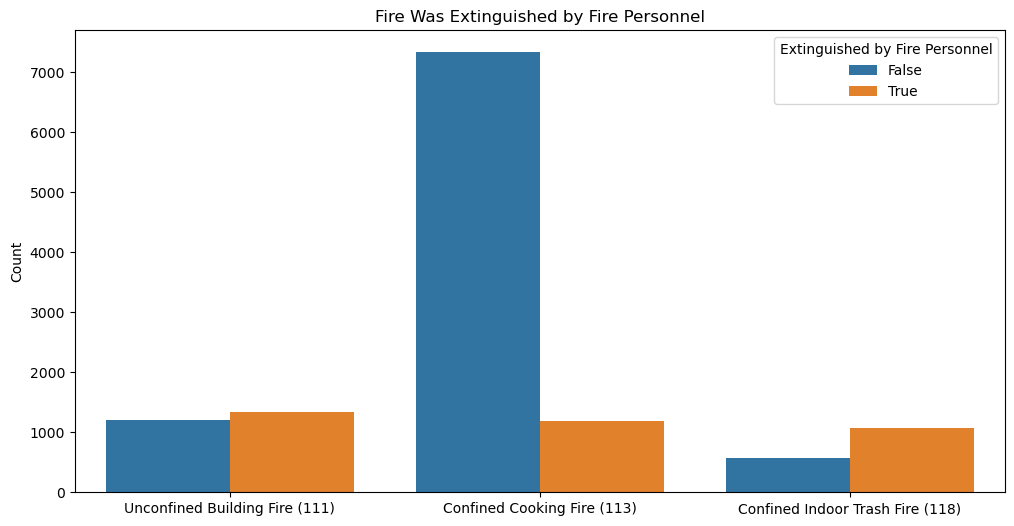

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame
grouped_data = df[df.bi_inc_type.isin([111, 118, 113])].groupby(['bi_inc_type', 'putoutfire']).size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.barplot(x='bi_inc_type', y='count', hue='putoutfire', data=grouped_data)

plt.title('Fire Was Extinguished by Fire Personnel')
plt.ylabel('Count')
plt.xlabel('')
plt.legend(title='Extinguished by Fire Personnel')

# Custom X labels
custom_x_labels = ["Unconfined Building Fire (111)", "Confined Cooking Fire (113)", "Confined Indoor Trash Fire (118)"]
plt.xticks(ticks=range(len(custom_x_labels)), labels=custom_x_labels)

plt.show()


In [40]:
inctype = 111
display(df[df.bi_inc_type == inctype].groupby('bi_act_tak1').size().sort_values(ascending=False).head(5) / len(df[df.bi_inc_type == inctype]))
display(df[df.bi_inc_type == inctype].groupby('bi_act_tak2').size().sort_values(ascending=False).head(5) / len(df[df.bi_inc_type == inctype]))
display(df[df.bi_inc_type == inctype].groupby('bi_act_tak3').size().sort_values(ascending=False).head(5) / len(df[df.bi_inc_type == inctype]))

bi_act_tak1
11.0    0.466929
86.0    0.090945
10.0    0.081102
87.0    0.062992
73.0    0.059843
dtype: float64

bi_act_tak2
NONE_REPORTED    0.505118
12               0.131102
51               0.095276
11               0.050394
86               0.047638
dtype: float64

bi_act_tak3
NONE_REPORTED    0.716535
51               0.057087
86               0.044882
12               0.043701
81               0.023228
dtype: float64

In [41]:
inctype = 113
display(df[df.bi_inc_type == inctype].groupby('bi_act_tak1').size().sort_values(ascending=False).head(5) / len(df[df.bi_inc_type == inctype]))
display(df[df.bi_inc_type == inctype].groupby('bi_act_tak2').size().sort_values(ascending=False).head(5) / len(df[df.bi_inc_type == inctype]))
display(df[df.bi_inc_type == inctype].groupby('bi_act_tak3').size().sort_values(ascending=False).head(5) / len(df[df.bi_inc_type == inctype]))

bi_act_tak1
86.0    0.390244
11.0    0.132622
51.0    0.131684
87.0    0.103307
81.0    0.061093
dtype: float64

bi_act_tak2
NONE_REPORTED    0.543035
51               0.211304
63               0.066839
86               0.061327
 -               0.027322
dtype: float64

bi_act_tak3
NONE_REPORTED    0.862922
63               0.040103
51               0.025094
 -               0.014775
86               0.012078
dtype: float64

In [42]:
inctype = 118
display(df[df.bi_inc_type == inctype].groupby('bi_act_tak1').size().sort_values(ascending=False).head(5) / len(df[df.bi_inc_type == inctype]))
display(df[df.bi_inc_type == inctype].groupby('bi_act_tak2').size().sort_values(ascending=False).head(5) / len(df[df.bi_inc_type == inctype]))
display(df[df.bi_inc_type == inctype].groupby('bi_act_tak3').size().sort_values(ascending=False).head(5) / len(df[df.bi_inc_type == inctype]))

bi_act_tak1
11.0    0.614964
10.0    0.138686
86.0    0.103406
87.0    0.044404
81.0    0.025547
dtype: float64

bi_act_tak2
NONE_REPORTED    0.521290
51               0.294404
11               0.042579
86               0.040146
21               0.033455
dtype: float64

bi_act_tak3
NONE_REPORTED    0.872871
51               0.041971
21               0.021290
11               0.009124
86               0.009124
dtype: float64

In [43]:
vet['total_indoor_12_20'] = vet[[f'building_fires_{x}' for x in range(2012, 2021)]].sum(axis=1)
vet['total_unconfined_12_20'] = vet[[f'inc_type_111_{x}' for x in range(2012, 2021)]].sum(axis=1)
vet['total_inj_12_20'] = vet[[f'oth_inj_{x}' for x in range(2012, 2021)]].sum(axis=1)

In [44]:
def calc_simple_index(row):
    total = 0
    if row.total_indoor_12_20 > 6:
        total += 3
    elif row.total_indoor_12_20 > 3:
        total += 2
    elif row.total_indoor_12_20 >= 1:
        total += 1

    if row.total_unconfined_12_20 > 0:
        total += 3

    if row.total_inj_12_20 > 0:
        total += 3

    if row.total_units > 100:
        total += 1

    if row.pct_median < 20:
        total += 1

    if row.eldly_prcnt >= 40:
        total += 1

    if row.pct_disabled_all >= 40:
        total += 1
    return total

vet['simple_index'] = vet.apply(calc_simple_index, axis=1)

In [45]:
test = vet[vet.building_type_code_es == 1].copy()
test = test.sort_values('simple_index', ascending=False)

In [46]:
from sklearn.preprocessing import MinMaxScaler
test.simple_index = MinMaxScaler().fit_transform(test.loc[:, ['simple_index']])

<Axes: title={'center': 'Weighted Average Fire Risk Index'}, xlabel='Normalized Index Value', ylabel='Number of Elevator Structures'>

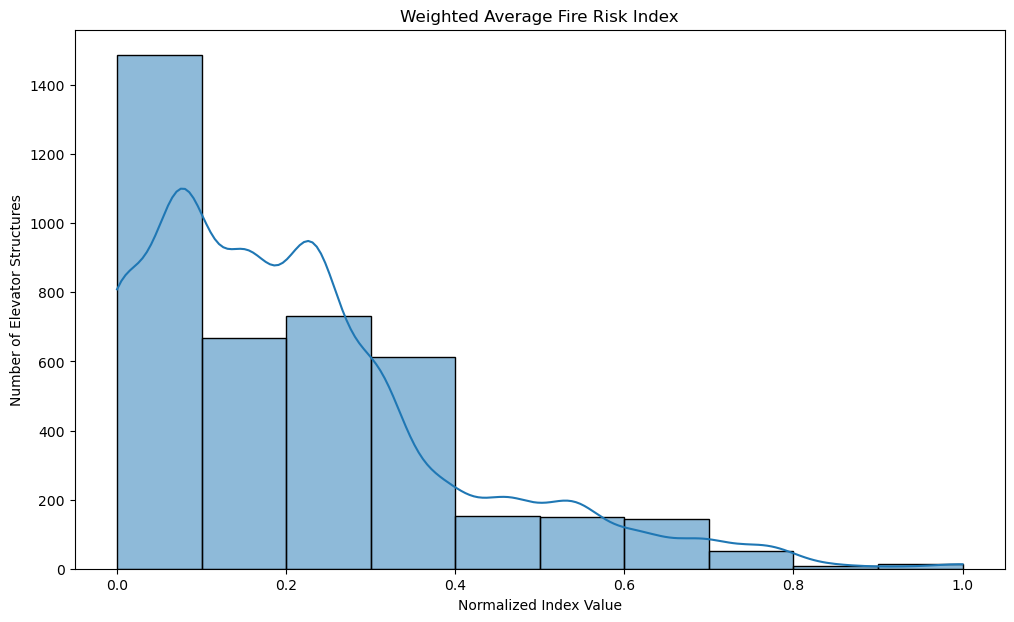

In [47]:
plt.figure(figsize=(12, 7))
plt.title('Weighted Average Fire Risk Index')
plt.ylabel('Number of Elevator Structures')
plt.xlabel('Normalized Index Value')
sns.histplot(data=test.simple_index, bins=10, kde=True)

Normal fires
* Recall 25% | Precision .33
* Recall 50% | Precision .29
* Recall 75% | Precision .17

Unconfined fires

76 total
25% recall | Precision 10%

In [48]:
h = test.head(300)
h[h.inc_type_111_2021 > 0].shape[0]

23

In [49]:
public[public.building_type_code == 'ES'].shape[0] / public.shape[0]

0.021351330223831982

In [50]:
public[public.building_type_code == 'ES'].total_units.sum() / public.total_units.sum()

0.37362427036305035

In [51]:
vet.total_111

118205    1.0
132747    0.0
49885     1.0
4100      2.0
98653     0.0
         ... 
60527     0.0
60529     0.0
60530     0.0
60531     0.0
179042    0.0
Name: total_111, Length: 179043, dtype: float64

In [52]:
vet[vet.total_111 == 0][[f'building_fires_{x}' for x in range(2012, 2021)]].sum(axis=1).mean()

0.03487353893260871